# Miller age

In [1]:
ood_seed = 4

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Bud tip progenitor', '15.0'), 338)


Removed datapoint: 338

train         5612
validation    1455
ood            338
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 97882.56it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 1007552.75it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 251.70it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:02<18:56,  2.85s/it]

Epoch 1/400:   0%|          | 1/400 [00:02<18:56,  2.85s/it, v_num=1, recon=1.19e+3, r2_mean=0.0584, adv_loss=3.39, acc_pert=0.337, acc_integration_donor=0.161]

Epoch 2/400:   0%|          | 1/400 [00:02<18:56,  2.85s/it, v_num=1, recon=1.19e+3, r2_mean=0.0584, adv_loss=3.39, acc_pert=0.337, acc_integration_donor=0.161]

Epoch 2/400:   0%|          | 2/400 [00:05<17:29,  2.64s/it, v_num=1, recon=1.19e+3, r2_mean=0.0584, adv_loss=3.39, acc_pert=0.337, acc_integration_donor=0.161]

Epoch 2/400:   0%|          | 2/400 [00:05<17:29,  2.64s/it, v_num=1, recon=1e+3, r2_mean=0.278, adv_loss=2.92, acc_pert=0.479, acc_integration_donor=0.341]    

Epoch 3/400:   0%|          | 2/400 [00:05<17:29,  2.64s/it, v_num=1, recon=1e+3, r2_mean=0.278, adv_loss=2.92, acc_pert=0.479, acc_integration_donor=0.341]

Epoch 3/400:   1%|          | 3/400 [00:07<16:51,  2.55s/it, v_num=1, recon=1e+3, r2_mean=0.278, adv_loss=2.92, acc_pert=0.479, acc_integration_donor=0.341]

Epoch 3/400:   1%|          | 3/400 [00:07<16:51,  2.55s/it, v_num=1, recon=932, r2_mean=0.361, adv_loss=2.58, acc_pert=0.522, acc_integration_donor=0.476] 

Epoch 4/400:   1%|          | 3/400 [00:07<16:51,  2.55s/it, v_num=1, recon=932, r2_mean=0.361, adv_loss=2.58, acc_pert=0.522, acc_integration_donor=0.476]

Epoch 4/400:   1%|          | 4/400 [00:10<16:26,  2.49s/it, v_num=1, recon=932, r2_mean=0.361, adv_loss=2.58, acc_pert=0.522, acc_integration_donor=0.476]

Epoch 4/400:   1%|          | 4/400 [00:10<16:26,  2.49s/it, v_num=1, recon=897, r2_mean=0.412, adv_loss=2.4, acc_pert=0.554, acc_integration_donor=0.522] 

Epoch 5/400:   1%|          | 4/400 [00:10<16:26,  2.49s/it, v_num=1, recon=897, r2_mean=0.412, adv_loss=2.4, acc_pert=0.554, acc_integration_donor=0.522]

Epoch 5/400:   1%|▏         | 5/400 [00:12<16:17,  2.47s/it, v_num=1, recon=897, r2_mean=0.412, adv_loss=2.4, acc_pert=0.554, acc_integration_donor=0.522]

Epoch 5/400:   1%|▏         | 5/400 [00:12<16:17,  2.47s/it, v_num=1, recon=879, r2_mean=0.433, adv_loss=2.3, acc_pert=0.55, acc_integration_donor=0.542] 

Epoch 6/400:   1%|▏         | 5/400 [00:12<16:17,  2.47s/it, v_num=1, recon=879, r2_mean=0.433, adv_loss=2.3, acc_pert=0.55, acc_integration_donor=0.542]

Epoch 6/400:   2%|▏         | 6/400 [00:15<16:08,  2.46s/it, v_num=1, recon=879, r2_mean=0.433, adv_loss=2.3, acc_pert=0.55, acc_integration_donor=0.542]

Epoch 6/400:   2%|▏         | 6/400 [00:15<16:08,  2.46s/it, v_num=1, recon=867, r2_mean=0.447, adv_loss=2.26, acc_pert=0.55, acc_integration_donor=0.554]

Epoch 7/400:   2%|▏         | 6/400 [00:15<16:08,  2.46s/it, v_num=1, recon=867, r2_mean=0.447, adv_loss=2.26, acc_pert=0.55, acc_integration_donor=0.554]

Epoch 7/400:   2%|▏         | 7/400 [00:17<16:03,  2.45s/it, v_num=1, recon=867, r2_mean=0.447, adv_loss=2.26, acc_pert=0.55, acc_integration_donor=0.554]

Epoch 7/400:   2%|▏         | 7/400 [00:17<16:03,  2.45s/it, v_num=1, recon=858, r2_mean=0.456, adv_loss=2.22, acc_pert=0.547, acc_integration_donor=0.554]

Epoch 8/400:   2%|▏         | 7/400 [00:17<16:03,  2.45s/it, v_num=1, recon=858, r2_mean=0.456, adv_loss=2.22, acc_pert=0.547, acc_integration_donor=0.554]

Epoch 8/400:   2%|▏         | 8/400 [00:19<15:58,  2.44s/it, v_num=1, recon=858, r2_mean=0.456, adv_loss=2.22, acc_pert=0.547, acc_integration_donor=0.554]

Epoch 8/400:   2%|▏         | 8/400 [00:19<15:58,  2.44s/it, v_num=1, recon=852, r2_mean=0.465, adv_loss=2.18, acc_pert=0.561, acc_integration_donor=0.545]

Epoch 9/400:   2%|▏         | 8/400 [00:19<15:58,  2.44s/it, v_num=1, recon=852, r2_mean=0.465, adv_loss=2.18, acc_pert=0.561, acc_integration_donor=0.545]

Epoch 9/400:   2%|▏         | 9/400 [00:22<15:55,  2.44s/it, v_num=1, recon=852, r2_mean=0.465, adv_loss=2.18, acc_pert=0.561, acc_integration_donor=0.545]

Epoch 9/400:   2%|▏         | 9/400 [00:22<15:55,  2.44s/it, v_num=1, recon=846, r2_mean=0.469, adv_loss=2.15, acc_pert=0.572, acc_integration_donor=0.535]

Epoch 10/400:   2%|▏         | 9/400 [00:22<15:55,  2.44s/it, v_num=1, recon=846, r2_mean=0.469, adv_loss=2.15, acc_pert=0.572, acc_integration_donor=0.535]


disnt_basal = 0.5375899702330076

disnt_after = 0.9293381592489522

val_r2_mean = 0.4828032248963912

val_r2_var = 0.19606161676347256


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:36<38:47,  5.97s/it, v_num=1, recon=846, r2_mean=0.469, adv_loss=2.15, acc_pert=0.572, acc_integration_donor=0.535]

Epoch 10/400:   2%|▎         | 10/400 [00:36<38:47,  5.97s/it, v_num=1, recon=841, r2_mean=0.475, adv_loss=2.14, acc_pert=0.567, acc_integration_donor=0.536, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:36<38:47,  5.97s/it, v_num=1, recon=841, r2_mean=0.475, adv_loss=2.14, acc_pert=0.567, acc_integration_donor=0.536, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:39<32:39,  5.04s/it, v_num=1, recon=841, r2_mean=0.475, adv_loss=2.14, acc_pert=0.567, acc_integration_donor=0.536, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:39<32:39,  5.04s/it, v_num=1, recon=836, r2_mean=0.477, adv_loss=2.13, acc_pert=0.569, acc_integration_donor=0.539, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:39<32:39,  5.04s/it, v_num=1, recon=836, r2_mean=0.477, adv_loss=2.13, acc_pert=0.569, acc_integration_donor=0.539, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:41<27:41,  4.28s/it, v_num=1, recon=836, r2_mean=0.477, adv_loss=2.13, acc_pert=0.569, acc_integration_donor=0.539, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:41<27:41,  4.28s/it, v_num=1, recon=832, r2_mean=0.485, adv_loss=2.15, acc_pert=0.561, acc_integration_donor=0.523, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:41<27:41,  4.28s/it, v_num=1, recon=832, r2_mean=0.485, adv_loss=2.15, acc_pert=0.561, acc_integration_donor=0.523, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:44<24:02,  3.73s/it, v_num=1, recon=832, r2_mean=0.485, adv_loss=2.15, acc_pert=0.561, acc_integration_donor=0.523, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:44<24:02,  3.73s/it, v_num=1, recon=828, r2_mean=0.495, adv_loss=2.16, acc_pert=0.555, acc_integration_donor=0.519, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:44<24:02,  3.73s/it, v_num=1, recon=828, r2_mean=0.495, adv_loss=2.16, acc_pert=0.555, acc_integration_donor=0.519, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:46<21:42,  3.37s/it, v_num=1, recon=828, r2_mean=0.495, adv_loss=2.16, acc_pert=0.555, acc_integration_donor=0.519, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:46<21:42,  3.37s/it, v_num=1, recon=825, r2_mean=0.49, adv_loss=2.16, acc_pert=0.548, acc_integration_donor=0.523, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan] 

Epoch 15/400:   4%|▎         | 14/400 [00:46<21:42,  3.37s/it, v_num=1, recon=825, r2_mean=0.49, adv_loss=2.16, acc_pert=0.548, acc_integration_donor=0.523, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:49<20:04,  3.13s/it, v_num=1, recon=825, r2_mean=0.49, adv_loss=2.16, acc_pert=0.548, acc_integration_donor=0.523, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:49<20:04,  3.13s/it, v_num=1, recon=823, r2_mean=0.5, adv_loss=2.17, acc_pert=0.55, acc_integration_donor=0.521, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]  

Epoch 16/400:   4%|▍         | 15/400 [00:49<20:04,  3.13s/it, v_num=1, recon=823, r2_mean=0.5, adv_loss=2.17, acc_pert=0.55, acc_integration_donor=0.521, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:51<18:54,  2.95s/it, v_num=1, recon=823, r2_mean=0.5, adv_loss=2.17, acc_pert=0.55, acc_integration_donor=0.521, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:51<18:54,  2.95s/it, v_num=1, recon=821, r2_mean=0.496, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.525, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:51<18:54,  2.95s/it, v_num=1, recon=821, r2_mean=0.496, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.525, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:54<17:56,  2.81s/it, v_num=1, recon=821, r2_mean=0.496, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.525, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:54<17:56,  2.81s/it, v_num=1, recon=817, r2_mean=0.505, adv_loss=2.15, acc_pert=0.55, acc_integration_donor=0.523, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:54<17:56,  2.81s/it, v_num=1, recon=817, r2_mean=0.505, adv_loss=2.15, acc_pert=0.55, acc_integration_donor=0.523, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:56<17:07,  2.69s/it, v_num=1, recon=817, r2_mean=0.505, adv_loss=2.15, acc_pert=0.55, acc_integration_donor=0.523, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:56<17:07,  2.69s/it, v_num=1, recon=815, r2_mean=0.507, adv_loss=2.13, acc_pert=0.563, acc_integration_donor=0.529, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [00:56<17:07,  2.69s/it, v_num=1, recon=815, r2_mean=0.507, adv_loss=2.13, acc_pert=0.563, acc_integration_donor=0.529, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:59<16:36,  2.62s/it, v_num=1, recon=815, r2_mean=0.507, adv_loss=2.13, acc_pert=0.563, acc_integration_donor=0.529, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:59<16:36,  2.62s/it, v_num=1, recon=813, r2_mean=0.512, adv_loss=2.13, acc_pert=0.553, acc_integration_donor=0.532, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [00:59<16:36,  2.62s/it, v_num=1, recon=813, r2_mean=0.512, adv_loss=2.13, acc_pert=0.553, acc_integration_donor=0.532, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]


disnt_basal = 0.5348194274322271

disnt_after = 0.9211538804620347

val_r2_mean = 0.4869221585492293

val_r2_var = 0.29808273042241734


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:05<24:00,  3.79s/it, v_num=1, recon=813, r2_mean=0.512, adv_loss=2.13, acc_pert=0.553, acc_integration_donor=0.532, val_recon=870, disnt_basal=0.538, disnt_after=0.929, val_r2_mean=0.483, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:05<24:00,  3.79s/it, v_num=1, recon=811, r2_mean=0.516, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.525, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan] 

Epoch 21/400:   5%|▌         | 20/400 [01:05<24:00,  3.79s/it, v_num=1, recon=811, r2_mean=0.516, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.525, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:08<21:27,  3.40s/it, v_num=1, recon=811, r2_mean=0.516, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.525, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:08<21:27,  3.40s/it, v_num=1, recon=809, r2_mean=0.515, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.534, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:08<21:27,  3.40s/it, v_num=1, recon=809, r2_mean=0.515, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.534, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:10<19:36,  3.11s/it, v_num=1, recon=809, r2_mean=0.515, adv_loss=2.17, acc_pert=0.544, acc_integration_donor=0.534, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:10<19:36,  3.11s/it, v_num=1, recon=808, r2_mean=0.516, adv_loss=2.17, acc_pert=0.549, acc_integration_donor=0.529, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:10<19:36,  3.11s/it, v_num=1, recon=808, r2_mean=0.516, adv_loss=2.17, acc_pert=0.549, acc_integration_donor=0.529, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:13<18:20,  2.92s/it, v_num=1, recon=808, r2_mean=0.516, adv_loss=2.17, acc_pert=0.549, acc_integration_donor=0.529, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:13<18:20,  2.92s/it, v_num=1, recon=806, r2_mean=0.516, adv_loss=2.13, acc_pert=0.554, acc_integration_donor=0.533, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:13<18:20,  2.92s/it, v_num=1, recon=806, r2_mean=0.516, adv_loss=2.13, acc_pert=0.554, acc_integration_donor=0.533, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:15<17:21,  2.77s/it, v_num=1, recon=806, r2_mean=0.516, adv_loss=2.13, acc_pert=0.554, acc_integration_donor=0.533, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:15<17:21,  2.77s/it, v_num=1, recon=804, r2_mean=0.52, adv_loss=2.11, acc_pert=0.558, acc_integration_donor=0.531, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [01:15<17:21,  2.77s/it, v_num=1, recon=804, r2_mean=0.52, adv_loss=2.11, acc_pert=0.558, acc_integration_donor=0.531, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:17<16:42,  2.67s/it, v_num=1, recon=804, r2_mean=0.52, adv_loss=2.11, acc_pert=0.558, acc_integration_donor=0.531, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:17<16:42,  2.67s/it, v_num=1, recon=802, r2_mean=0.521, adv_loss=2.11, acc_pert=0.559, acc_integration_donor=0.531, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:17<16:42,  2.67s/it, v_num=1, recon=802, r2_mean=0.521, adv_loss=2.11, acc_pert=0.559, acc_integration_donor=0.531, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:20<16:17,  2.61s/it, v_num=1, recon=802, r2_mean=0.521, adv_loss=2.11, acc_pert=0.559, acc_integration_donor=0.531, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:20<16:17,  2.61s/it, v_num=1, recon=801, r2_mean=0.521, adv_loss=2.13, acc_pert=0.558, acc_integration_donor=0.527, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:20<16:17,  2.61s/it, v_num=1, recon=801, r2_mean=0.521, adv_loss=2.13, acc_pert=0.558, acc_integration_donor=0.527, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:22<15:52,  2.55s/it, v_num=1, recon=801, r2_mean=0.521, adv_loss=2.13, acc_pert=0.558, acc_integration_donor=0.527, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:22<15:52,  2.55s/it, v_num=1, recon=799, r2_mean=0.523, adv_loss=2.15, acc_pert=0.548, acc_integration_donor=0.531, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:22<15:52,  2.55s/it, v_num=1, recon=799, r2_mean=0.523, adv_loss=2.15, acc_pert=0.548, acc_integration_donor=0.531, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:25<15:39,  2.52s/it, v_num=1, recon=799, r2_mean=0.523, adv_loss=2.15, acc_pert=0.548, acc_integration_donor=0.531, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:25<15:39,  2.52s/it, v_num=1, recon=798, r2_mean=0.525, adv_loss=2.15, acc_pert=0.549, acc_integration_donor=0.527, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:25<15:39,  2.52s/it, v_num=1, recon=798, r2_mean=0.525, adv_loss=2.15, acc_pert=0.549, acc_integration_donor=0.527, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:27<15:26,  2.50s/it, v_num=1, recon=798, r2_mean=0.525, adv_loss=2.15, acc_pert=0.549, acc_integration_donor=0.527, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:27<15:26,  2.50s/it, v_num=1, recon=797, r2_mean=0.527, adv_loss=2.15, acc_pert=0.549, acc_integration_donor=0.53, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [01:27<15:26,  2.50s/it, v_num=1, recon=797, r2_mean=0.527, adv_loss=2.15, acc_pert=0.549, acc_integration_donor=0.53, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]


disnt_basal = 0.5208435225623823

disnt_after = 0.9231798963219054

val_r2_mean = 0.4864958915859461

val_r2_var = 0.3250227688501279


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:37<28:21,  4.60s/it, v_num=1, recon=797, r2_mean=0.527, adv_loss=2.15, acc_pert=0.549, acc_integration_donor=0.53, val_recon=845, disnt_basal=0.535, disnt_after=0.921, val_r2_mean=0.487, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:37<28:21,  4.60s/it, v_num=1, recon=796, r2_mean=0.529, adv_loss=2.17, acc_pert=0.545, acc_integration_donor=0.532, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:37<28:21,  4.60s/it, v_num=1, recon=796, r2_mean=0.529, adv_loss=2.17, acc_pert=0.545, acc_integration_donor=0.532, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:40<25:17,  4.11s/it, v_num=1, recon=796, r2_mean=0.529, adv_loss=2.17, acc_pert=0.545, acc_integration_donor=0.532, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:40<25:17,  4.11s/it, v_num=1, recon=795, r2_mean=0.528, adv_loss=2.17, acc_pert=0.529, acc_integration_donor=0.528, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:40<25:17,  4.11s/it, v_num=1, recon=795, r2_mean=0.528, adv_loss=2.17, acc_pert=0.529, acc_integration_donor=0.528, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:42<22:08,  3.61s/it, v_num=1, recon=795, r2_mean=0.528, adv_loss=2.17, acc_pert=0.529, acc_integration_donor=0.528, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:42<22:08,  3.61s/it, v_num=1, recon=794, r2_mean=0.53, adv_loss=2.18, acc_pert=0.532, acc_integration_donor=0.53, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]  

Epoch 33/400:   8%|▊         | 32/400 [01:42<22:08,  3.61s/it, v_num=1, recon=794, r2_mean=0.53, adv_loss=2.18, acc_pert=0.532, acc_integration_donor=0.53, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:45<19:55,  3.26s/it, v_num=1, recon=794, r2_mean=0.53, adv_loss=2.18, acc_pert=0.532, acc_integration_donor=0.53, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:45<19:55,  3.26s/it, v_num=1, recon=792, r2_mean=0.531, adv_loss=2.17, acc_pert=0.525, acc_integration_donor=0.534, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [01:45<19:55,  3.26s/it, v_num=1, recon=792, r2_mean=0.531, adv_loss=2.17, acc_pert=0.525, acc_integration_donor=0.534, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:47<18:24,  3.02s/it, v_num=1, recon=792, r2_mean=0.531, adv_loss=2.17, acc_pert=0.525, acc_integration_donor=0.534, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:47<18:24,  3.02s/it, v_num=1, recon=791, r2_mean=0.535, adv_loss=2.18, acc_pert=0.528, acc_integration_donor=0.536, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [01:47<18:24,  3.02s/it, v_num=1, recon=791, r2_mean=0.535, adv_loss=2.18, acc_pert=0.528, acc_integration_donor=0.536, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:49<17:18,  2.85s/it, v_num=1, recon=791, r2_mean=0.535, adv_loss=2.18, acc_pert=0.528, acc_integration_donor=0.536, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:49<17:18,  2.85s/it, v_num=1, recon=790, r2_mean=0.533, adv_loss=2.18, acc_pert=0.525, acc_integration_donor=0.53, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [01:49<17:18,  2.85s/it, v_num=1, recon=790, r2_mean=0.533, adv_loss=2.18, acc_pert=0.525, acc_integration_donor=0.53, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:52<16:30,  2.72s/it, v_num=1, recon=790, r2_mean=0.533, adv_loss=2.18, acc_pert=0.525, acc_integration_donor=0.53, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:52<16:30,  2.72s/it, v_num=1, recon=789, r2_mean=0.536, adv_loss=2.17, acc_pert=0.535, acc_integration_donor=0.53, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [01:52<16:30,  2.72s/it, v_num=1, recon=789, r2_mean=0.536, adv_loss=2.17, acc_pert=0.535, acc_integration_donor=0.53, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:54<15:59,  2.64s/it, v_num=1, recon=789, r2_mean=0.536, adv_loss=2.17, acc_pert=0.535, acc_integration_donor=0.53, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:54<15:59,  2.64s/it, v_num=1, recon=788, r2_mean=0.537, adv_loss=2.17, acc_pert=0.53, acc_integration_donor=0.526, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [01:54<15:59,  2.64s/it, v_num=1, recon=788, r2_mean=0.537, adv_loss=2.17, acc_pert=0.53, acc_integration_donor=0.526, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:57<15:30,  2.57s/it, v_num=1, recon=788, r2_mean=0.537, adv_loss=2.17, acc_pert=0.53, acc_integration_donor=0.526, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:57<15:30,  2.57s/it, v_num=1, recon=787, r2_mean=0.539, adv_loss=2.17, acc_pert=0.534, acc_integration_donor=0.535, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [01:57<15:30,  2.57s/it, v_num=1, recon=787, r2_mean=0.539, adv_loss=2.17, acc_pert=0.534, acc_integration_donor=0.535, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:59<15:12,  2.53s/it, v_num=1, recon=787, r2_mean=0.539, adv_loss=2.17, acc_pert=0.534, acc_integration_donor=0.535, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:59<15:12,  2.53s/it, v_num=1, recon=785, r2_mean=0.537, adv_loss=2.21, acc_pert=0.517, acc_integration_donor=0.529, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [01:59<15:12,  2.53s/it, v_num=1, recon=785, r2_mean=0.537, adv_loss=2.21, acc_pert=0.517, acc_integration_donor=0.529, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]


disnt_basal = 0.5212892160675212

disnt_after = 0.9343206169139152

val_r2_mean = 0.4780624080449343

val_r2_var = 0.34186146408319473


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [02:11<31:35,  5.26s/it, v_num=1, recon=785, r2_mean=0.537, adv_loss=2.21, acc_pert=0.517, acc_integration_donor=0.529, val_recon=838, disnt_basal=0.521, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [02:11<31:35,  5.26s/it, v_num=1, recon=784, r2_mean=0.54, adv_loss=2.2, acc_pert=0.52, acc_integration_donor=0.528, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]   

Epoch 41/400:  10%|█         | 40/400 [02:11<31:35,  5.26s/it, v_num=1, recon=784, r2_mean=0.54, adv_loss=2.2, acc_pert=0.52, acc_integration_donor=0.528, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:13<26:38,  4.45s/it, v_num=1, recon=784, r2_mean=0.54, adv_loss=2.2, acc_pert=0.52, acc_integration_donor=0.528, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:13<26:38,  4.45s/it, v_num=1, recon=783, r2_mean=0.543, adv_loss=2.21, acc_pert=0.521, acc_integration_donor=0.526, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [02:13<26:38,  4.45s/it, v_num=1, recon=783, r2_mean=0.543, adv_loss=2.21, acc_pert=0.521, acc_integration_donor=0.526, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:16<22:59,  3.85s/it, v_num=1, recon=783, r2_mean=0.543, adv_loss=2.21, acc_pert=0.521, acc_integration_donor=0.526, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:16<22:59,  3.85s/it, v_num=1, recon=783, r2_mean=0.543, adv_loss=2.2, acc_pert=0.529, acc_integration_donor=0.531, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan] 

Epoch 43/400:  10%|█         | 42/400 [02:16<22:59,  3.85s/it, v_num=1, recon=783, r2_mean=0.543, adv_loss=2.2, acc_pert=0.529, acc_integration_donor=0.531, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:18<20:35,  3.46s/it, v_num=1, recon=783, r2_mean=0.543, adv_loss=2.2, acc_pert=0.529, acc_integration_donor=0.531, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:18<20:35,  3.46s/it, v_num=1, recon=781, r2_mean=0.545, adv_loss=2.2, acc_pert=0.52, acc_integration_donor=0.53, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]  

Epoch 44/400:  11%|█         | 43/400 [02:18<20:35,  3.46s/it, v_num=1, recon=781, r2_mean=0.545, adv_loss=2.2, acc_pert=0.52, acc_integration_donor=0.53, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:21<18:45,  3.16s/it, v_num=1, recon=781, r2_mean=0.545, adv_loss=2.2, acc_pert=0.52, acc_integration_donor=0.53, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:21<18:45,  3.16s/it, v_num=1, recon=781, r2_mean=0.544, adv_loss=2.19, acc_pert=0.513, acc_integration_donor=0.533, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [02:21<18:45,  3.16s/it, v_num=1, recon=781, r2_mean=0.544, adv_loss=2.19, acc_pert=0.513, acc_integration_donor=0.533, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:23<17:32,  2.96s/it, v_num=1, recon=781, r2_mean=0.544, adv_loss=2.19, acc_pert=0.513, acc_integration_donor=0.533, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:23<17:32,  2.96s/it, v_num=1, recon=780, r2_mean=0.542, adv_loss=2.19, acc_pert=0.53, acc_integration_donor=0.528, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan] 

Epoch 46/400:  11%|█▏        | 45/400 [02:23<17:32,  2.96s/it, v_num=1, recon=780, r2_mean=0.542, adv_loss=2.19, acc_pert=0.53, acc_integration_donor=0.528, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:26<16:46,  2.84s/it, v_num=1, recon=780, r2_mean=0.542, adv_loss=2.19, acc_pert=0.53, acc_integration_donor=0.528, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:26<16:46,  2.84s/it, v_num=1, recon=779, r2_mean=0.542, adv_loss=2.19, acc_pert=0.53, acc_integration_donor=0.53, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan] 

Epoch 47/400:  12%|█▏        | 46/400 [02:26<16:46,  2.84s/it, v_num=1, recon=779, r2_mean=0.542, adv_loss=2.19, acc_pert=0.53, acc_integration_donor=0.53, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:28<16:02,  2.73s/it, v_num=1, recon=779, r2_mean=0.542, adv_loss=2.19, acc_pert=0.53, acc_integration_donor=0.53, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:28<16:02,  2.73s/it, v_num=1, recon=778, r2_mean=0.548, adv_loss=2.2, acc_pert=0.522, acc_integration_donor=0.53, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [02:28<16:02,  2.73s/it, v_num=1, recon=778, r2_mean=0.548, adv_loss=2.2, acc_pert=0.522, acc_integration_donor=0.53, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:31<15:32,  2.65s/it, v_num=1, recon=778, r2_mean=0.548, adv_loss=2.2, acc_pert=0.522, acc_integration_donor=0.53, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:31<15:32,  2.65s/it, v_num=1, recon=777, r2_mean=0.545, adv_loss=2.21, acc_pert=0.523, acc_integration_donor=0.526, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [02:31<15:32,  2.65s/it, v_num=1, recon=777, r2_mean=0.545, adv_loss=2.21, acc_pert=0.523, acc_integration_donor=0.526, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:33<15:09,  2.59s/it, v_num=1, recon=777, r2_mean=0.545, adv_loss=2.21, acc_pert=0.523, acc_integration_donor=0.526, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:33<15:09,  2.59s/it, v_num=1, recon=776, r2_mean=0.55, adv_loss=2.2, acc_pert=0.526, acc_integration_donor=0.532, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]  

Epoch 50/400:  12%|█▏        | 49/400 [02:33<15:09,  2.59s/it, v_num=1, recon=776, r2_mean=0.55, adv_loss=2.2, acc_pert=0.526, acc_integration_donor=0.532, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]


disnt_basal = 0.517217977652347

disnt_after = 0.9351335465395598

val_r2_mean = 0.4869179477294286

val_r2_var = 0.3545423857867718


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [02:47<35:07,  6.02s/it, v_num=1, recon=776, r2_mean=0.55, adv_loss=2.2, acc_pert=0.526, acc_integration_donor=0.532, val_recon=832, disnt_basal=0.521, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [02:47<35:07,  6.02s/it, v_num=1, recon=775, r2_mean=0.55, adv_loss=2.21, acc_pert=0.511, acc_integration_donor=0.531, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [02:47<35:07,  6.02s/it, v_num=1, recon=775, r2_mean=0.55, adv_loss=2.21, acc_pert=0.511, acc_integration_donor=0.531, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:50<28:51,  4.96s/it, v_num=1, recon=775, r2_mean=0.55, adv_loss=2.21, acc_pert=0.511, acc_integration_donor=0.531, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:50<28:51,  4.96s/it, v_num=1, recon=774, r2_mean=0.545, adv_loss=2.19, acc_pert=0.522, acc_integration_donor=0.528, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [02:50<28:51,  4.96s/it, v_num=1, recon=774, r2_mean=0.545, adv_loss=2.19, acc_pert=0.522, acc_integration_donor=0.528, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:53<25:04,  4.32s/it, v_num=1, recon=774, r2_mean=0.545, adv_loss=2.19, acc_pert=0.522, acc_integration_donor=0.528, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:53<25:04,  4.32s/it, v_num=1, recon=773, r2_mean=0.55, adv_loss=2.22, acc_pert=0.521, acc_integration_donor=0.522, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan] 

Epoch 53/400:  13%|█▎        | 52/400 [02:53<25:04,  4.32s/it, v_num=1, recon=773, r2_mean=0.55, adv_loss=2.22, acc_pert=0.521, acc_integration_donor=0.522, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:55<21:42,  3.75s/it, v_num=1, recon=773, r2_mean=0.55, adv_loss=2.22, acc_pert=0.521, acc_integration_donor=0.522, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:55<21:42,  3.75s/it, v_num=1, recon=772, r2_mean=0.55, adv_loss=2.2, acc_pert=0.526, acc_integration_donor=0.527, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [02:55<21:42,  3.75s/it, v_num=1, recon=772, r2_mean=0.55, adv_loss=2.2, acc_pert=0.526, acc_integration_donor=0.527, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:57<19:18,  3.35s/it, v_num=1, recon=772, r2_mean=0.55, adv_loss=2.2, acc_pert=0.526, acc_integration_donor=0.527, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:57<19:18,  3.35s/it, v_num=1, recon=771, r2_mean=0.552, adv_loss=2.21, acc_pert=0.522, acc_integration_donor=0.53, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [02:57<19:18,  3.35s/it, v_num=1, recon=771, r2_mean=0.552, adv_loss=2.21, acc_pert=0.522, acc_integration_donor=0.53, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:00<17:40,  3.07s/it, v_num=1, recon=771, r2_mean=0.552, adv_loss=2.21, acc_pert=0.522, acc_integration_donor=0.53, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:00<17:40,  3.07s/it, v_num=1, recon=770, r2_mean=0.556, adv_loss=2.21, acc_pert=0.52, acc_integration_donor=0.537, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [03:00<17:40,  3.07s/it, v_num=1, recon=770, r2_mean=0.556, adv_loss=2.21, acc_pert=0.52, acc_integration_donor=0.537, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:02<16:28,  2.87s/it, v_num=1, recon=770, r2_mean=0.556, adv_loss=2.21, acc_pert=0.52, acc_integration_donor=0.537, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:02<16:28,  2.87s/it, v_num=1, recon=769, r2_mean=0.555, adv_loss=2.2, acc_pert=0.519, acc_integration_donor=0.53, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan] 

Epoch 57/400:  14%|█▍        | 56/400 [03:02<16:28,  2.87s/it, v_num=1, recon=769, r2_mean=0.555, adv_loss=2.2, acc_pert=0.519, acc_integration_donor=0.53, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:05<15:37,  2.73s/it, v_num=1, recon=769, r2_mean=0.555, adv_loss=2.2, acc_pert=0.519, acc_integration_donor=0.53, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:05<15:37,  2.73s/it, v_num=1, recon=768, r2_mean=0.556, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.529, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [03:05<15:37,  2.73s/it, v_num=1, recon=768, r2_mean=0.556, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.529, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:07<15:01,  2.64s/it, v_num=1, recon=768, r2_mean=0.556, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.529, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:07<15:01,  2.64s/it, v_num=1, recon=767, r2_mean=0.558, adv_loss=2.23, acc_pert=0.522, acc_integration_donor=0.523, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [03:07<15:01,  2.64s/it, v_num=1, recon=767, r2_mean=0.558, adv_loss=2.23, acc_pert=0.522, acc_integration_donor=0.523, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:10<14:32,  2.56s/it, v_num=1, recon=767, r2_mean=0.558, adv_loss=2.23, acc_pert=0.522, acc_integration_donor=0.523, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:10<14:32,  2.56s/it, v_num=1, recon=766, r2_mean=0.557, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.527, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [03:10<14:32,  2.56s/it, v_num=1, recon=766, r2_mean=0.557, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.527, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]


disnt_basal = 0.5213042317951363

disnt_after = 0.9218629493500115

val_r2_mean = 0.4883905512591203

val_r2_var = 0.3668937844534715

Epoch 60/400:  15%|█▌        | 60/400 [03:18<24:16,  4.28s/it, v_num=1, recon=766, r2_mean=0.557, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.527, val_recon=827, disnt_basal=0.517, disnt_after=0.935, val_r2_mean=0.487, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:18<24:16,  4.28s/it, v_num=1, recon=765, r2_mean=0.556, adv_loss=2.21, acc_pert=0.524, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [03:18<24:16,  4.28s/it, v_num=1, recon=765, r2_mean=0.556, adv_loss=2.21, acc_pert=0.524, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:20<21:00,  3.72s/it, v_num=1, recon=765, r2_mean=0.556, adv_loss=2.21, acc_pert=0.524, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:20<21:00,  3.72s/it, v_num=1, recon=765, r2_mean=0.557, adv_loss=2.23, acc_pert=0.509, acc_integration_donor=0.532, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [03:20<21:00,  3.72s/it, v_num=1, recon=765, r2_mean=0.557, adv_loss=2.23, acc_pert=0.509, acc_integration_donor=0.532, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:23<18:45,  3.33s/it, v_num=1, recon=765, r2_mean=0.557, adv_loss=2.23, acc_pert=0.509, acc_integration_donor=0.532, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:23<18:45,  3.33s/it, v_num=1, recon=764, r2_mean=0.55, adv_loss=2.24, acc_pert=0.511, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan] 

Epoch 63/400:  16%|█▌        | 62/400 [03:23<18:45,  3.33s/it, v_num=1, recon=764, r2_mean=0.55, adv_loss=2.24, acc_pert=0.511, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:25<17:11,  3.06s/it, v_num=1, recon=764, r2_mean=0.55, adv_loss=2.24, acc_pert=0.511, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:25<17:11,  3.06s/it, v_num=1, recon=763, r2_mean=0.555, adv_loss=2.22, acc_pert=0.511, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [03:25<17:11,  3.06s/it, v_num=1, recon=763, r2_mean=0.555, adv_loss=2.22, acc_pert=0.511, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:28<16:08,  2.88s/it, v_num=1, recon=763, r2_mean=0.555, adv_loss=2.22, acc_pert=0.511, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:28<16:08,  2.88s/it, v_num=1, recon=762, r2_mean=0.561, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.521, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [03:28<16:08,  2.88s/it, v_num=1, recon=762, r2_mean=0.561, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.521, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:30<15:17,  2.74s/it, v_num=1, recon=762, r2_mean=0.561, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.521, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:30<15:17,  2.74s/it, v_num=1, recon=761, r2_mean=0.56, adv_loss=2.22, acc_pert=0.515, acc_integration_donor=0.533, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan] 

Epoch 66/400:  16%|█▋        | 65/400 [03:30<15:17,  2.74s/it, v_num=1, recon=761, r2_mean=0.56, adv_loss=2.22, acc_pert=0.515, acc_integration_donor=0.533, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:32<14:42,  2.64s/it, v_num=1, recon=761, r2_mean=0.56, adv_loss=2.22, acc_pert=0.515, acc_integration_donor=0.533, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:32<14:42,  2.64s/it, v_num=1, recon=760, r2_mean=0.559, adv_loss=2.23, acc_pert=0.518, acc_integration_donor=0.526, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [03:32<14:42,  2.64s/it, v_num=1, recon=760, r2_mean=0.559, adv_loss=2.23, acc_pert=0.518, acc_integration_donor=0.526, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:35<14:17,  2.58s/it, v_num=1, recon=760, r2_mean=0.559, adv_loss=2.23, acc_pert=0.518, acc_integration_donor=0.526, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:35<14:17,  2.58s/it, v_num=1, recon=759, r2_mean=0.562, adv_loss=2.24, acc_pert=0.51, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan] 

Epoch 68/400:  17%|█▋        | 67/400 [03:35<14:17,  2.58s/it, v_num=1, recon=759, r2_mean=0.562, adv_loss=2.24, acc_pert=0.51, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:37<13:58,  2.53s/it, v_num=1, recon=759, r2_mean=0.562, adv_loss=2.24, acc_pert=0.51, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:37<13:58,  2.53s/it, v_num=1, recon=759, r2_mean=0.563, adv_loss=2.23, acc_pert=0.519, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [03:37<13:58,  2.53s/it, v_num=1, recon=759, r2_mean=0.563, adv_loss=2.23, acc_pert=0.519, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:40<13:43,  2.49s/it, v_num=1, recon=759, r2_mean=0.563, adv_loss=2.23, acc_pert=0.519, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:40<13:43,  2.49s/it, v_num=1, recon=758, r2_mean=0.559, adv_loss=2.23, acc_pert=0.516, acc_integration_donor=0.524, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [03:40<13:43,  2.49s/it, v_num=1, recon=758, r2_mean=0.559, adv_loss=2.23, acc_pert=0.516, acc_integration_donor=0.524, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]


disnt_basal = 0.5069922713850955

disnt_after = 0.9367650395851922

val_r2_mean = 0.48524941441913444

val_r2_var = 0.3676381806532542


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [03:50<26:26,  4.81s/it, v_num=1, recon=758, r2_mean=0.559, adv_loss=2.23, acc_pert=0.516, acc_integration_donor=0.524, val_recon=835, disnt_basal=0.521, disnt_after=0.922, val_r2_mean=0.488, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [03:50<26:26,  4.81s/it, v_num=1, recon=757, r2_mean=0.562, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.526, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [03:50<26:26,  4.81s/it, v_num=1, recon=757, r2_mean=0.562, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.526, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [03:52<22:33,  4.11s/it, v_num=1, recon=757, r2_mean=0.562, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.526, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [03:52<22:33,  4.11s/it, v_num=1, recon=757, r2_mean=0.565, adv_loss=2.23, acc_pert=0.506, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan] 

Epoch 72/400:  18%|█▊        | 71/400 [03:52<22:33,  4.11s/it, v_num=1, recon=757, r2_mean=0.565, adv_loss=2.23, acc_pert=0.506, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [03:55<19:46,  3.62s/it, v_num=1, recon=757, r2_mean=0.565, adv_loss=2.23, acc_pert=0.506, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [03:55<19:46,  3.62s/it, v_num=1, recon=755, r2_mean=0.561, adv_loss=2.23, acc_pert=0.517, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [03:55<19:46,  3.62s/it, v_num=1, recon=755, r2_mean=0.561, adv_loss=2.23, acc_pert=0.517, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [03:57<17:45,  3.26s/it, v_num=1, recon=755, r2_mean=0.561, adv_loss=2.23, acc_pert=0.517, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [03:57<17:45,  3.26s/it, v_num=1, recon=755, r2_mean=0.566, adv_loss=2.23, acc_pert=0.512, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [03:57<17:45,  3.26s/it, v_num=1, recon=755, r2_mean=0.566, adv_loss=2.23, acc_pert=0.512, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:00<16:23,  3.02s/it, v_num=1, recon=755, r2_mean=0.566, adv_loss=2.23, acc_pert=0.512, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:00<16:23,  3.02s/it, v_num=1, recon=754, r2_mean=0.568, adv_loss=2.24, acc_pert=0.517, acc_integration_donor=0.525, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [04:00<16:23,  3.02s/it, v_num=1, recon=754, r2_mean=0.568, adv_loss=2.24, acc_pert=0.517, acc_integration_donor=0.525, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:02<15:25,  2.85s/it, v_num=1, recon=754, r2_mean=0.568, adv_loss=2.24, acc_pert=0.517, acc_integration_donor=0.525, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:02<15:25,  2.85s/it, v_num=1, recon=753, r2_mean=0.564, adv_loss=2.24, acc_pert=0.512, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [04:02<15:25,  2.85s/it, v_num=1, recon=753, r2_mean=0.564, adv_loss=2.24, acc_pert=0.512, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:05<14:44,  2.73s/it, v_num=1, recon=753, r2_mean=0.564, adv_loss=2.24, acc_pert=0.512, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:05<14:44,  2.73s/it, v_num=1, recon=752, r2_mean=0.567, adv_loss=2.24, acc_pert=0.509, acc_integration_donor=0.518, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [04:05<14:44,  2.73s/it, v_num=1, recon=752, r2_mean=0.567, adv_loss=2.24, acc_pert=0.509, acc_integration_donor=0.518, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:07<14:15,  2.65s/it, v_num=1, recon=752, r2_mean=0.567, adv_loss=2.24, acc_pert=0.509, acc_integration_donor=0.518, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:07<14:15,  2.65s/it, v_num=1, recon=751, r2_mean=0.567, adv_loss=2.21, acc_pert=0.515, acc_integration_donor=0.529, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [04:07<14:15,  2.65s/it, v_num=1, recon=751, r2_mean=0.567, adv_loss=2.21, acc_pert=0.515, acc_integration_donor=0.529, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:09<13:51,  2.58s/it, v_num=1, recon=751, r2_mean=0.567, adv_loss=2.21, acc_pert=0.515, acc_integration_donor=0.529, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:09<13:51,  2.58s/it, v_num=1, recon=751, r2_mean=0.565, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [04:09<13:51,  2.58s/it, v_num=1, recon=751, r2_mean=0.565, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:12<13:32,  2.53s/it, v_num=1, recon=751, r2_mean=0.565, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.528, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:12<13:32,  2.53s/it, v_num=1, recon=750, r2_mean=0.568, adv_loss=2.23, acc_pert=0.521, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan] 

Epoch 80/400:  20%|█▉        | 79/400 [04:12<13:32,  2.53s/it, v_num=1, recon=750, r2_mean=0.568, adv_loss=2.23, acc_pert=0.521, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]


disnt_basal = 0.49935559911334493

disnt_after = 0.9362193854269862

val_r2_mean = 0.489004743595918

val_r2_var = 0.37117177061736584


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [04:28<35:54,  6.73s/it, v_num=1, recon=750, r2_mean=0.568, adv_loss=2.23, acc_pert=0.521, acc_integration_donor=0.53, val_recon=829, disnt_basal=0.507, disnt_after=0.937, val_r2_mean=0.485, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [04:28<35:54,  6.73s/it, v_num=1, recon=748, r2_mean=0.572, adv_loss=2.22, acc_pert=0.515, acc_integration_donor=0.529, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [04:28<35:54,  6.73s/it, v_num=1, recon=748, r2_mean=0.572, adv_loss=2.22, acc_pert=0.515, acc_integration_donor=0.529, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:31<29:14,  5.50s/it, v_num=1, recon=748, r2_mean=0.572, adv_loss=2.22, acc_pert=0.515, acc_integration_donor=0.529, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:31<29:14,  5.50s/it, v_num=1, recon=748, r2_mean=0.571, adv_loss=2.24, acc_pert=0.518, acc_integration_donor=0.527, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [04:31<29:14,  5.50s/it, v_num=1, recon=748, r2_mean=0.571, adv_loss=2.24, acc_pert=0.518, acc_integration_donor=0.527, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:34<24:22,  4.60s/it, v_num=1, recon=748, r2_mean=0.571, adv_loss=2.24, acc_pert=0.518, acc_integration_donor=0.527, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:34<24:22,  4.60s/it, v_num=1, recon=747, r2_mean=0.57, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.523, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan] 

Epoch 83/400:  20%|██        | 82/400 [04:34<24:22,  4.60s/it, v_num=1, recon=747, r2_mean=0.57, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.523, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:36<20:54,  3.96s/it, v_num=1, recon=747, r2_mean=0.57, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.523, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:36<20:54,  3.96s/it, v_num=1, recon=746, r2_mean=0.571, adv_loss=2.23, acc_pert=0.517, acc_integration_donor=0.53, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [04:36<20:54,  3.96s/it, v_num=1, recon=746, r2_mean=0.571, adv_loss=2.23, acc_pert=0.517, acc_integration_donor=0.53, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:38<18:33,  3.52s/it, v_num=1, recon=746, r2_mean=0.571, adv_loss=2.23, acc_pert=0.517, acc_integration_donor=0.53, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:38<18:33,  3.52s/it, v_num=1, recon=745, r2_mean=0.571, adv_loss=2.24, acc_pert=0.518, acc_integration_donor=0.524, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [04:38<18:33,  3.52s/it, v_num=1, recon=745, r2_mean=0.571, adv_loss=2.24, acc_pert=0.518, acc_integration_donor=0.524, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:41<16:59,  3.24s/it, v_num=1, recon=745, r2_mean=0.571, adv_loss=2.24, acc_pert=0.518, acc_integration_donor=0.524, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:41<16:59,  3.24s/it, v_num=1, recon=744, r2_mean=0.573, adv_loss=2.24, acc_pert=0.512, acc_integration_donor=0.53, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan] 

Epoch 86/400:  21%|██▏       | 85/400 [04:41<16:59,  3.24s/it, v_num=1, recon=744, r2_mean=0.573, adv_loss=2.24, acc_pert=0.512, acc_integration_donor=0.53, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:44<15:43,  3.00s/it, v_num=1, recon=744, r2_mean=0.573, adv_loss=2.24, acc_pert=0.512, acc_integration_donor=0.53, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:44<15:43,  3.00s/it, v_num=1, recon=743, r2_mean=0.573, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.531, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [04:44<15:43,  3.00s/it, v_num=1, recon=743, r2_mean=0.573, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.531, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:46<14:50,  2.84s/it, v_num=1, recon=743, r2_mean=0.573, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.531, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:46<14:50,  2.84s/it, v_num=1, recon=742, r2_mean=0.574, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.532, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [04:46<14:50,  2.84s/it, v_num=1, recon=742, r2_mean=0.574, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.532, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:48<14:16,  2.75s/it, v_num=1, recon=742, r2_mean=0.574, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.532, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:49<14:16,  2.75s/it, v_num=1, recon=742, r2_mean=0.574, adv_loss=2.23, acc_pert=0.515, acc_integration_donor=0.529, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [04:49<14:16,  2.75s/it, v_num=1, recon=742, r2_mean=0.574, adv_loss=2.23, acc_pert=0.515, acc_integration_donor=0.529, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [04:51<13:48,  2.66s/it, v_num=1, recon=742, r2_mean=0.574, adv_loss=2.23, acc_pert=0.515, acc_integration_donor=0.529, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [04:51<13:48,  2.66s/it, v_num=1, recon=741, r2_mean=0.575, adv_loss=2.26, acc_pert=0.514, acc_integration_donor=0.518, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [04:51<13:48,  2.66s/it, v_num=1, recon=741, r2_mean=0.575, adv_loss=2.26, acc_pert=0.514, acc_integration_donor=0.518, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]


disnt_basal = 0.4956919406820008

disnt_after = 0.9073514027841765

val_r2_mean = 0.4893386084586382

val_r2_var = 0.3768990244716406

Epoch 90/400:  22%|██▎       | 90/400 [05:04<29:39,  5.74s/it, v_num=1, recon=741, r2_mean=0.575, adv_loss=2.26, acc_pert=0.514, acc_integration_donor=0.518, val_recon=831, disnt_basal=0.499, disnt_after=0.936, val_r2_mean=0.489, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [05:04<29:39,  5.74s/it, v_num=1, recon=740, r2_mean=0.573, adv_loss=2.26, acc_pert=0.515, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [05:04<29:39,  5.74s/it, v_num=1, recon=740, r2_mean=0.573, adv_loss=2.26, acc_pert=0.515, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:06<24:25,  4.74s/it, v_num=1, recon=740, r2_mean=0.573, adv_loss=2.26, acc_pert=0.515, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:06<24:25,  4.74s/it, v_num=1, recon=740, r2_mean=0.577, adv_loss=2.25, acc_pert=0.512, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [05:06<24:25,  4.74s/it, v_num=1, recon=740, r2_mean=0.577, adv_loss=2.25, acc_pert=0.512, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:09<21:11,  4.13s/it, v_num=1, recon=740, r2_mean=0.577, adv_loss=2.25, acc_pert=0.512, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:09<21:11,  4.13s/it, v_num=1, recon=739, r2_mean=0.573, adv_loss=2.26, acc_pert=0.51, acc_integration_donor=0.529, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan] 

Epoch 93/400:  23%|██▎       | 92/400 [05:09<21:11,  4.13s/it, v_num=1, recon=739, r2_mean=0.573, adv_loss=2.26, acc_pert=0.51, acc_integration_donor=0.529, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:12<18:56,  3.70s/it, v_num=1, recon=739, r2_mean=0.573, adv_loss=2.26, acc_pert=0.51, acc_integration_donor=0.529, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:12<18:56,  3.70s/it, v_num=1, recon=738, r2_mean=0.572, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [05:12<18:56,  3.70s/it, v_num=1, recon=738, r2_mean=0.572, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:14<17:20,  3.40s/it, v_num=1, recon=738, r2_mean=0.572, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:14<17:20,  3.40s/it, v_num=1, recon=738, r2_mean=0.573, adv_loss=2.25, acc_pert=0.511, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [05:14<17:20,  3.40s/it, v_num=1, recon=738, r2_mean=0.573, adv_loss=2.25, acc_pert=0.511, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:17<16:13,  3.19s/it, v_num=1, recon=738, r2_mean=0.573, adv_loss=2.25, acc_pert=0.511, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:17<16:13,  3.19s/it, v_num=1, recon=737, r2_mean=0.577, adv_loss=2.24, acc_pert=0.506, acc_integration_donor=0.531, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [05:17<16:13,  3.19s/it, v_num=1, recon=737, r2_mean=0.577, adv_loss=2.24, acc_pert=0.506, acc_integration_donor=0.531, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:20<15:24,  3.04s/it, v_num=1, recon=737, r2_mean=0.577, adv_loss=2.24, acc_pert=0.506, acc_integration_donor=0.531, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:20<15:24,  3.04s/it, v_num=1, recon=736, r2_mean=0.576, adv_loss=2.24, acc_pert=0.51, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan] 

Epoch 97/400:  24%|██▍       | 96/400 [05:20<15:24,  3.04s/it, v_num=1, recon=736, r2_mean=0.576, adv_loss=2.24, acc_pert=0.51, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:22<14:50,  2.94s/it, v_num=1, recon=736, r2_mean=0.576, adv_loss=2.24, acc_pert=0.51, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:23<14:50,  2.94s/it, v_num=1, recon=735, r2_mean=0.573, adv_loss=2.25, acc_pert=0.509, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [05:23<14:50,  2.94s/it, v_num=1, recon=735, r2_mean=0.573, adv_loss=2.25, acc_pert=0.509, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:25<14:27,  2.87s/it, v_num=1, recon=735, r2_mean=0.573, adv_loss=2.25, acc_pert=0.509, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:25<14:27,  2.87s/it, v_num=1, recon=734, r2_mean=0.581, adv_loss=2.24, acc_pert=0.515, acc_integration_donor=0.527, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [05:25<14:27,  2.87s/it, v_num=1, recon=734, r2_mean=0.581, adv_loss=2.24, acc_pert=0.515, acc_integration_donor=0.527, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:28<14:08,  2.82s/it, v_num=1, recon=734, r2_mean=0.581, adv_loss=2.24, acc_pert=0.515, acc_integration_donor=0.527, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:28<14:08,  2.82s/it, v_num=1, recon=733, r2_mean=0.582, adv_loss=2.24, acc_pert=0.509, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [05:28<14:08,  2.82s/it, v_num=1, recon=733, r2_mean=0.582, adv_loss=2.24, acc_pert=0.509, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]


disnt_basal = 0.501375977525298

disnt_after = 0.9191607498933526

val_r2_mean = 0.49198669461267336

val_r2_var = 0.37549968755670954

Epoch 100/400:  25%|██▌       | 100/400 [05:46<36:56,  7.39s/it, v_num=1, recon=733, r2_mean=0.582, adv_loss=2.24, acc_pert=0.509, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.496, disnt_after=0.907, val_r2_mean=0.489, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [05:46<36:56,  7.39s/it, v_num=1, recon=733, r2_mean=0.58, adv_loss=2.25, acc_pert=0.506, acc_integration_donor=0.531, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan] 

Epoch 101/400:  25%|██▌       | 100/400 [05:46<36:56,  7.39s/it, v_num=1, recon=733, r2_mean=0.58, adv_loss=2.25, acc_pert=0.506, acc_integration_donor=0.531, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:48<29:26,  5.91s/it, v_num=1, recon=733, r2_mean=0.58, adv_loss=2.25, acc_pert=0.506, acc_integration_donor=0.531, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:48<29:26,  5.91s/it, v_num=1, recon=731, r2_mean=0.579, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.532, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [05:48<29:26,  5.91s/it, v_num=1, recon=731, r2_mean=0.579, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.532, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [05:51<24:08,  4.86s/it, v_num=1, recon=731, r2_mean=0.579, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.532, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [05:51<24:08,  4.86s/it, v_num=1, recon=730, r2_mean=0.582, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.529, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [05:51<24:08,  4.86s/it, v_num=1, recon=730, r2_mean=0.582, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.529, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [05:54<21:01,  4.25s/it, v_num=1, recon=730, r2_mean=0.582, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.529, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [05:54<21:01,  4.25s/it, v_num=1, recon=730, r2_mean=0.582, adv_loss=2.25, acc_pert=0.514, acc_integration_donor=0.526, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [05:54<21:01,  4.25s/it, v_num=1, recon=730, r2_mean=0.582, adv_loss=2.25, acc_pert=0.514, acc_integration_donor=0.526, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [05:56<18:43,  3.80s/it, v_num=1, recon=730, r2_mean=0.582, adv_loss=2.25, acc_pert=0.514, acc_integration_donor=0.526, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [05:56<18:43,  3.80s/it, v_num=1, recon=729, r2_mean=0.579, adv_loss=2.23, acc_pert=0.516, acc_integration_donor=0.524, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [05:56<18:43,  3.80s/it, v_num=1, recon=729, r2_mean=0.579, adv_loss=2.23, acc_pert=0.516, acc_integration_donor=0.524, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [05:59<16:42,  3.40s/it, v_num=1, recon=729, r2_mean=0.579, adv_loss=2.23, acc_pert=0.516, acc_integration_donor=0.524, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [05:59<16:42,  3.40s/it, v_num=1, recon=729, r2_mean=0.579, adv_loss=2.24, acc_pert=0.528, acc_integration_donor=0.528, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [05:59<16:42,  3.40s/it, v_num=1, recon=729, r2_mean=0.579, adv_loss=2.24, acc_pert=0.528, acc_integration_donor=0.528, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:01<15:15,  3.11s/it, v_num=1, recon=729, r2_mean=0.579, adv_loss=2.24, acc_pert=0.528, acc_integration_donor=0.528, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:01<15:15,  3.11s/it, v_num=1, recon=727, r2_mean=0.584, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.529, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [06:01<15:15,  3.11s/it, v_num=1, recon=727, r2_mean=0.584, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.529, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:04<14:13,  2.91s/it, v_num=1, recon=727, r2_mean=0.584, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.529, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:04<14:13,  2.91s/it, v_num=1, recon=727, r2_mean=0.585, adv_loss=2.24, acc_pert=0.5, acc_integration_donor=0.525, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]  

Epoch 108/400:  27%|██▋       | 107/400 [06:04<14:13,  2.91s/it, v_num=1, recon=727, r2_mean=0.585, adv_loss=2.24, acc_pert=0.5, acc_integration_donor=0.525, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:06<13:30,  2.78s/it, v_num=1, recon=727, r2_mean=0.585, adv_loss=2.24, acc_pert=0.5, acc_integration_donor=0.525, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:06<13:30,  2.78s/it, v_num=1, recon=727, r2_mean=0.582, adv_loss=2.24, acc_pert=0.509, acc_integration_donor=0.523, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [06:06<13:30,  2.78s/it, v_num=1, recon=727, r2_mean=0.582, adv_loss=2.24, acc_pert=0.509, acc_integration_donor=0.523, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:09<12:58,  2.67s/it, v_num=1, recon=727, r2_mean=0.582, adv_loss=2.24, acc_pert=0.509, acc_integration_donor=0.523, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:09<12:58,  2.67s/it, v_num=1, recon=726, r2_mean=0.585, adv_loss=2.23, acc_pert=0.52, acc_integration_donor=0.529, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [06:09<12:58,  2.67s/it, v_num=1, recon=726, r2_mean=0.585, adv_loss=2.23, acc_pert=0.52, acc_integration_donor=0.529, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]


disnt_basal = 0.49472812747793066

disnt_after = 0.9197493869927724

val_r2_mean = 0.4861544326302551

val_r2_var = 0.37349886686674183

Epoch 110/400:  28%|██▊       | 110/400 [06:19<24:02,  4.97s/it, v_num=1, recon=726, r2_mean=0.585, adv_loss=2.23, acc_pert=0.52, acc_integration_donor=0.529, val_recon=838, disnt_basal=0.501, disnt_after=0.919, val_r2_mean=0.492, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [06:19<24:02,  4.97s/it, v_num=1, recon=725, r2_mean=0.584, adv_loss=2.22, acc_pert=0.514, acc_integration_donor=0.53, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan] 

Epoch 111/400:  28%|██▊       | 110/400 [06:19<24:02,  4.97s/it, v_num=1, recon=725, r2_mean=0.584, adv_loss=2.22, acc_pert=0.514, acc_integration_donor=0.53, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:21<20:20,  4.22s/it, v_num=1, recon=725, r2_mean=0.584, adv_loss=2.22, acc_pert=0.514, acc_integration_donor=0.53, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:21<20:20,  4.22s/it, v_num=1, recon=724, r2_mean=0.585, adv_loss=2.24, acc_pert=0.519, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [06:21<20:20,  4.22s/it, v_num=1, recon=724, r2_mean=0.585, adv_loss=2.24, acc_pert=0.519, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:24<17:41,  3.69s/it, v_num=1, recon=724, r2_mean=0.585, adv_loss=2.24, acc_pert=0.519, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:24<17:41,  3.69s/it, v_num=1, recon=723, r2_mean=0.587, adv_loss=2.24, acc_pert=0.514, acc_integration_donor=0.525, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [06:24<17:41,  3.69s/it, v_num=1, recon=723, r2_mean=0.587, adv_loss=2.24, acc_pert=0.514, acc_integration_donor=0.525, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:26<15:49,  3.31s/it, v_num=1, recon=723, r2_mean=0.587, adv_loss=2.24, acc_pert=0.514, acc_integration_donor=0.525, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:26<15:49,  3.31s/it, v_num=1, recon=722, r2_mean=0.587, adv_loss=2.23, acc_pert=0.52, acc_integration_donor=0.528, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [06:26<15:49,  3.31s/it, v_num=1, recon=722, r2_mean=0.587, adv_loss=2.23, acc_pert=0.52, acc_integration_donor=0.528, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:29<14:30,  3.04s/it, v_num=1, recon=722, r2_mean=0.587, adv_loss=2.23, acc_pert=0.52, acc_integration_donor=0.528, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:29<14:30,  3.04s/it, v_num=1, recon=722, r2_mean=0.586, adv_loss=2.23, acc_pert=0.515, acc_integration_donor=0.532, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [06:29<14:30,  3.04s/it, v_num=1, recon=722, r2_mean=0.586, adv_loss=2.23, acc_pert=0.515, acc_integration_donor=0.532, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:31<13:35,  2.86s/it, v_num=1, recon=722, r2_mean=0.586, adv_loss=2.23, acc_pert=0.515, acc_integration_donor=0.532, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:31<13:35,  2.86s/it, v_num=1, recon=721, r2_mean=0.587, adv_loss=2.23, acc_pert=0.525, acc_integration_donor=0.528, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [06:31<13:35,  2.86s/it, v_num=1, recon=721, r2_mean=0.587, adv_loss=2.23, acc_pert=0.525, acc_integration_donor=0.528, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:34<12:57,  2.74s/it, v_num=1, recon=721, r2_mean=0.587, adv_loss=2.23, acc_pert=0.525, acc_integration_donor=0.528, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:34<12:57,  2.74s/it, v_num=1, recon=720, r2_mean=0.588, adv_loss=2.25, acc_pert=0.52, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan] 

Epoch 117/400:  29%|██▉       | 116/400 [06:34<12:57,  2.74s/it, v_num=1, recon=720, r2_mean=0.588, adv_loss=2.25, acc_pert=0.52, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:36<12:31,  2.66s/it, v_num=1, recon=720, r2_mean=0.588, adv_loss=2.25, acc_pert=0.52, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:36<12:31,  2.66s/it, v_num=1, recon=719, r2_mean=0.588, adv_loss=2.22, acc_pert=0.522, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [06:36<12:31,  2.66s/it, v_num=1, recon=719, r2_mean=0.588, adv_loss=2.22, acc_pert=0.522, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:39<12:08,  2.58s/it, v_num=1, recon=719, r2_mean=0.588, adv_loss=2.22, acc_pert=0.522, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:39<12:08,  2.58s/it, v_num=1, recon=718, r2_mean=0.592, adv_loss=2.23, acc_pert=0.52, acc_integration_donor=0.523, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan] 

Epoch 119/400:  30%|██▉       | 118/400 [06:39<12:08,  2.58s/it, v_num=1, recon=718, r2_mean=0.592, adv_loss=2.23, acc_pert=0.52, acc_integration_donor=0.523, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:41<11:51,  2.53s/it, v_num=1, recon=718, r2_mean=0.592, adv_loss=2.23, acc_pert=0.52, acc_integration_donor=0.523, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:41<11:51,  2.53s/it, v_num=1, recon=718, r2_mean=0.588, adv_loss=2.23, acc_pert=0.523, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [06:41<11:51,  2.53s/it, v_num=1, recon=718, r2_mean=0.588, adv_loss=2.23, acc_pert=0.523, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]


disnt_basal = 0.48740776581702744

disnt_after = 0.9388424552854131

val_r2_mean = 0.4740279943992694

val_r2_var = 0.378975464651982


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [06:58<31:55,  6.84s/it, v_num=1, recon=718, r2_mean=0.588, adv_loss=2.23, acc_pert=0.523, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.495, disnt_after=0.92, val_r2_mean=0.486, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [06:58<31:55,  6.84s/it, v_num=1, recon=717, r2_mean=0.587, adv_loss=2.22, acc_pert=0.51, acc_integration_donor=0.52, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan] 

Epoch 121/400:  30%|███       | 120/400 [06:58<31:55,  6.84s/it, v_num=1, recon=717, r2_mean=0.587, adv_loss=2.22, acc_pert=0.51, acc_integration_donor=0.52, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:00<25:49,  5.55s/it, v_num=1, recon=717, r2_mean=0.587, adv_loss=2.22, acc_pert=0.51, acc_integration_donor=0.52, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:00<25:49,  5.55s/it, v_num=1, recon=716, r2_mean=0.591, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.532, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [07:00<25:49,  5.55s/it, v_num=1, recon=716, r2_mean=0.591, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.532, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:03<21:33,  4.65s/it, v_num=1, recon=716, r2_mean=0.591, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.532, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:03<21:33,  4.65s/it, v_num=1, recon=715, r2_mean=0.595, adv_loss=2.25, acc_pert=0.514, acc_integration_donor=0.525, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [07:03<21:33,  4.65s/it, v_num=1, recon=715, r2_mean=0.595, adv_loss=2.25, acc_pert=0.514, acc_integration_donor=0.525, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:06<18:38,  4.04s/it, v_num=1, recon=715, r2_mean=0.595, adv_loss=2.25, acc_pert=0.514, acc_integration_donor=0.525, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:06<18:38,  4.04s/it, v_num=1, recon=715, r2_mean=0.592, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.531, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [07:06<18:38,  4.04s/it, v_num=1, recon=715, r2_mean=0.592, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.531, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:08<16:29,  3.58s/it, v_num=1, recon=715, r2_mean=0.592, adv_loss=2.23, acc_pert=0.511, acc_integration_donor=0.531, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:08<16:29,  3.58s/it, v_num=1, recon=714, r2_mean=0.589, adv_loss=2.24, acc_pert=0.524, acc_integration_donor=0.521, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [07:08<16:29,  3.58s/it, v_num=1, recon=714, r2_mean=0.589, adv_loss=2.24, acc_pert=0.524, acc_integration_donor=0.521, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:11<15:00,  3.28s/it, v_num=1, recon=714, r2_mean=0.589, adv_loss=2.24, acc_pert=0.524, acc_integration_donor=0.521, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:11<15:00,  3.28s/it, v_num=1, recon=714, r2_mean=0.591, adv_loss=2.26, acc_pert=0.494, acc_integration_donor=0.526, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [07:11<15:00,  3.28s/it, v_num=1, recon=714, r2_mean=0.591, adv_loss=2.26, acc_pert=0.494, acc_integration_donor=0.526, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:13<13:57,  3.06s/it, v_num=1, recon=714, r2_mean=0.591, adv_loss=2.26, acc_pert=0.494, acc_integration_donor=0.526, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:13<13:57,  3.06s/it, v_num=1, recon=713, r2_mean=0.594, adv_loss=2.21, acc_pert=0.525, acc_integration_donor=0.538, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [07:13<13:57,  3.06s/it, v_num=1, recon=713, r2_mean=0.594, adv_loss=2.21, acc_pert=0.525, acc_integration_donor=0.538, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:16<13:15,  2.92s/it, v_num=1, recon=713, r2_mean=0.594, adv_loss=2.21, acc_pert=0.525, acc_integration_donor=0.538, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:16<13:15,  2.92s/it, v_num=1, recon=712, r2_mean=0.597, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.525, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [07:16<13:15,  2.92s/it, v_num=1, recon=712, r2_mean=0.597, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.525, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:18<12:51,  2.84s/it, v_num=1, recon=712, r2_mean=0.597, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.525, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:18<12:51,  2.84s/it, v_num=1, recon=711, r2_mean=0.592, adv_loss=2.24, acc_pert=0.514, acc_integration_donor=0.529, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [07:18<12:51,  2.84s/it, v_num=1, recon=711, r2_mean=0.592, adv_loss=2.24, acc_pert=0.514, acc_integration_donor=0.529, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:21<12:23,  2.74s/it, v_num=1, recon=711, r2_mean=0.592, adv_loss=2.24, acc_pert=0.514, acc_integration_donor=0.529, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:21<12:23,  2.74s/it, v_num=1, recon=711, r2_mean=0.595, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.529, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [07:21<12:23,  2.74s/it, v_num=1, recon=711, r2_mean=0.595, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.529, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]


disnt_basal = 0.4921789577117357

disnt_after = 0.9350055173902462

val_r2_mean = 0.47591647257407504

val_r2_var = 0.3811539386709531

Epoch 130/400:  32%|███▎      | 130/400 [07:29<19:54,  4.43s/it, v_num=1, recon=711, r2_mean=0.595, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.529, val_recon=833, disnt_basal=0.487, disnt_after=0.939, val_r2_mean=0.474, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [07:29<19:54,  4.43s/it, v_num=1, recon=710, r2_mean=0.598, adv_loss=2.25, acc_pert=0.518, acc_integration_donor=0.523, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [07:29<19:54,  4.43s/it, v_num=1, recon=710, r2_mean=0.598, adv_loss=2.25, acc_pert=0.518, acc_integration_donor=0.523, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:32<17:14,  3.85s/it, v_num=1, recon=710, r2_mean=0.598, adv_loss=2.25, acc_pert=0.518, acc_integration_donor=0.523, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:32<17:14,  3.85s/it, v_num=1, recon=709, r2_mean=0.595, adv_loss=2.25, acc_pert=0.517, acc_integration_donor=0.521, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [07:32<17:14,  3.85s/it, v_num=1, recon=709, r2_mean=0.595, adv_loss=2.25, acc_pert=0.517, acc_integration_donor=0.521, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:34<15:17,  3.42s/it, v_num=1, recon=709, r2_mean=0.595, adv_loss=2.25, acc_pert=0.517, acc_integration_donor=0.521, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:34<15:17,  3.42s/it, v_num=1, recon=708, r2_mean=0.595, adv_loss=2.26, acc_pert=0.508, acc_integration_donor=0.525, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [07:34<15:17,  3.42s/it, v_num=1, recon=708, r2_mean=0.595, adv_loss=2.26, acc_pert=0.508, acc_integration_donor=0.525, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:37<13:53,  3.12s/it, v_num=1, recon=708, r2_mean=0.595, adv_loss=2.26, acc_pert=0.508, acc_integration_donor=0.525, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:37<13:53,  3.12s/it, v_num=1, recon=709, r2_mean=0.593, adv_loss=2.25, acc_pert=0.507, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [07:37<13:53,  3.12s/it, v_num=1, recon=709, r2_mean=0.593, adv_loss=2.25, acc_pert=0.507, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [07:39<12:54,  2.91s/it, v_num=1, recon=709, r2_mean=0.593, adv_loss=2.25, acc_pert=0.507, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [07:39<12:54,  2.91s/it, v_num=1, recon=708, r2_mean=0.593, adv_loss=2.23, acc_pert=0.52, acc_integration_donor=0.522, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [07:39<12:54,  2.91s/it, v_num=1, recon=708, r2_mean=0.593, adv_loss=2.23, acc_pert=0.52, acc_integration_donor=0.522, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:41<12:14,  2.77s/it, v_num=1, recon=708, r2_mean=0.593, adv_loss=2.23, acc_pert=0.52, acc_integration_donor=0.522, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:41<12:14,  2.77s/it, v_num=1, recon=707, r2_mean=0.601, adv_loss=2.23, acc_pert=0.524, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [07:41<12:14,  2.77s/it, v_num=1, recon=707, r2_mean=0.601, adv_loss=2.23, acc_pert=0.524, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:44<11:44,  2.67s/it, v_num=1, recon=707, r2_mean=0.601, adv_loss=2.23, acc_pert=0.524, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:44<11:44,  2.67s/it, v_num=1, recon=706, r2_mean=0.599, adv_loss=2.25, acc_pert=0.51, acc_integration_donor=0.529, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan] 

Epoch 137/400:  34%|███▍      | 136/400 [07:44<11:44,  2.67s/it, v_num=1, recon=706, r2_mean=0.599, adv_loss=2.25, acc_pert=0.51, acc_integration_donor=0.529, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [07:46<11:20,  2.59s/it, v_num=1, recon=706, r2_mean=0.599, adv_loss=2.25, acc_pert=0.51, acc_integration_donor=0.529, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [07:46<11:20,  2.59s/it, v_num=1, recon=705, r2_mean=0.595, adv_loss=2.23, acc_pert=0.518, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [07:46<11:20,  2.59s/it, v_num=1, recon=705, r2_mean=0.595, adv_loss=2.23, acc_pert=0.518, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [07:49<11:04,  2.54s/it, v_num=1, recon=705, r2_mean=0.595, adv_loss=2.23, acc_pert=0.518, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [07:49<11:04,  2.54s/it, v_num=1, recon=704, r2_mean=0.598, adv_loss=2.23, acc_pert=0.519, acc_integration_donor=0.533, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [07:49<11:04,  2.54s/it, v_num=1, recon=704, r2_mean=0.598, adv_loss=2.23, acc_pert=0.519, acc_integration_donor=0.533, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [07:51<10:53,  2.50s/it, v_num=1, recon=704, r2_mean=0.598, adv_loss=2.23, acc_pert=0.519, acc_integration_donor=0.533, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [07:51<10:53,  2.50s/it, v_num=1, recon=704, r2_mean=0.6, adv_loss=2.23, acc_pert=0.518, acc_integration_donor=0.533, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]  

Epoch 140/400:  35%|███▍      | 139/400 [07:51<10:53,  2.50s/it, v_num=1, recon=704, r2_mean=0.6, adv_loss=2.23, acc_pert=0.518, acc_integration_donor=0.533, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]


disnt_basal = 0.48657796609859916

disnt_after = 0.9287505538632161

val_r2_mean = 0.4734227495888869

val_r2_var = 0.38670300506055355

Epoch 140/400:  35%|███▌      | 140/400 [08:01<20:44,  4.79s/it, v_num=1, recon=704, r2_mean=0.6, adv_loss=2.23, acc_pert=0.518, acc_integration_donor=0.533, val_recon=842, disnt_basal=0.492, disnt_after=0.935, val_r2_mean=0.476, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [08:01<20:44,  4.79s/it, v_num=1, recon=703, r2_mean=0.597, adv_loss=2.24, acc_pert=0.507, acc_integration_donor=0.528, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [08:01<20:44,  4.79s/it, v_num=1, recon=703, r2_mean=0.597, adv_loss=2.24, acc_pert=0.507, acc_integration_donor=0.528, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:04<17:35,  4.07s/it, v_num=1, recon=703, r2_mean=0.597, adv_loss=2.24, acc_pert=0.507, acc_integration_donor=0.528, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:04<17:35,  4.07s/it, v_num=1, recon=702, r2_mean=0.6, adv_loss=2.22, acc_pert=0.513, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]  

Epoch 142/400:  35%|███▌      | 141/400 [08:04<17:35,  4.07s/it, v_num=1, recon=702, r2_mean=0.6, adv_loss=2.22, acc_pert=0.513, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:09<18:56,  4.41s/it, v_num=1, recon=702, r2_mean=0.6, adv_loss=2.22, acc_pert=0.513, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:09<18:56,  4.41s/it, v_num=1, recon=702, r2_mean=0.6, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [08:09<18:56,  4.41s/it, v_num=1, recon=702, r2_mean=0.6, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:11<16:17,  3.80s/it, v_num=1, recon=702, r2_mean=0.6, adv_loss=2.24, acc_pert=0.516, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:11<16:17,  3.80s/it, v_num=1, recon=702, r2_mean=0.6, adv_loss=2.24, acc_pert=0.511, acc_integration_donor=0.526, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [08:11<16:17,  3.80s/it, v_num=1, recon=702, r2_mean=0.6, adv_loss=2.24, acc_pert=0.511, acc_integration_donor=0.526, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:14<14:28,  3.39s/it, v_num=1, recon=702, r2_mean=0.6, adv_loss=2.24, acc_pert=0.511, acc_integration_donor=0.526, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:14<14:28,  3.39s/it, v_num=1, recon=700, r2_mean=0.602, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [08:14<14:28,  3.39s/it, v_num=1, recon=700, r2_mean=0.602, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:16<13:12,  3.11s/it, v_num=1, recon=700, r2_mean=0.602, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:16<13:12,  3.11s/it, v_num=1, recon=699, r2_mean=0.603, adv_loss=2.24, acc_pert=0.506, acc_integration_donor=0.526, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [08:16<13:12,  3.11s/it, v_num=1, recon=699, r2_mean=0.603, adv_loss=2.24, acc_pert=0.506, acc_integration_donor=0.526, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:19<12:18,  2.91s/it, v_num=1, recon=699, r2_mean=0.603, adv_loss=2.24, acc_pert=0.506, acc_integration_donor=0.526, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:19<12:18,  2.91s/it, v_num=1, recon=699, r2_mean=0.6, adv_loss=2.22, acc_pert=0.523, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]   

Epoch 147/400:  36%|███▋      | 146/400 [08:19<12:18,  2.91s/it, v_num=1, recon=699, r2_mean=0.6, adv_loss=2.22, acc_pert=0.523, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:21<11:40,  2.77s/it, v_num=1, recon=699, r2_mean=0.6, adv_loss=2.22, acc_pert=0.523, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:21<11:40,  2.77s/it, v_num=1, recon=699, r2_mean=0.601, adv_loss=2.24, acc_pert=0.523, acc_integration_donor=0.529, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [08:21<11:40,  2.77s/it, v_num=1, recon=699, r2_mean=0.601, adv_loss=2.24, acc_pert=0.523, acc_integration_donor=0.529, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:23<11:14,  2.68s/it, v_num=1, recon=699, r2_mean=0.601, adv_loss=2.24, acc_pert=0.523, acc_integration_donor=0.529, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:23<11:14,  2.68s/it, v_num=1, recon=698, r2_mean=0.604, adv_loss=2.23, acc_pert=0.516, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [08:23<11:14,  2.68s/it, v_num=1, recon=698, r2_mean=0.604, adv_loss=2.23, acc_pert=0.516, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:26<10:53,  2.60s/it, v_num=1, recon=698, r2_mean=0.604, adv_loss=2.23, acc_pert=0.516, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:26<10:53,  2.60s/it, v_num=1, recon=697, r2_mean=0.604, adv_loss=2.21, acc_pert=0.519, acc_integration_donor=0.535, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [08:26<10:53,  2.60s/it, v_num=1, recon=697, r2_mean=0.604, adv_loss=2.21, acc_pert=0.519, acc_integration_donor=0.535, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]


disnt_basal = 0.4882791048258337

disnt_after = 0.9317727807109741

val_r2_mean = 0.4771229612330596

val_r2_var = 0.3768248185515404

Epoch 150/400:  38%|███▊      | 150/400 [08:39<23:33,  5.65s/it, v_num=1, recon=697, r2_mean=0.604, adv_loss=2.21, acc_pert=0.519, acc_integration_donor=0.535, val_recon=853, disnt_basal=0.487, disnt_after=0.929, val_r2_mean=0.473, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [08:39<23:33,  5.65s/it, v_num=1, recon=697, r2_mean=0.605, adv_loss=2.23, acc_pert=0.513, acc_integration_donor=0.528, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [08:39<23:33,  5.65s/it, v_num=1, recon=697, r2_mean=0.605, adv_loss=2.23, acc_pert=0.513, acc_integration_donor=0.528, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:41<19:52,  4.79s/it, v_num=1, recon=697, r2_mean=0.605, adv_loss=2.23, acc_pert=0.513, acc_integration_donor=0.528, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:41<19:52,  4.79s/it, v_num=1, recon=696, r2_mean=0.601, adv_loss=2.23, acc_pert=0.519, acc_integration_donor=0.532, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [08:41<19:52,  4.79s/it, v_num=1, recon=696, r2_mean=0.601, adv_loss=2.23, acc_pert=0.519, acc_integration_donor=0.532, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:44<17:17,  4.18s/it, v_num=1, recon=696, r2_mean=0.601, adv_loss=2.23, acc_pert=0.519, acc_integration_donor=0.532, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:44<17:17,  4.18s/it, v_num=1, recon=696, r2_mean=0.601, adv_loss=2.23, acc_pert=0.525, acc_integration_donor=0.528, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [08:44<17:17,  4.18s/it, v_num=1, recon=696, r2_mean=0.601, adv_loss=2.23, acc_pert=0.525, acc_integration_donor=0.528, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:47<15:09,  3.68s/it, v_num=1, recon=696, r2_mean=0.601, adv_loss=2.23, acc_pert=0.525, acc_integration_donor=0.528, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:47<15:09,  3.68s/it, v_num=1, recon=695, r2_mean=0.607, adv_loss=2.22, acc_pert=0.518, acc_integration_donor=0.53, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan] 

Epoch 154/400:  38%|███▊      | 153/400 [08:47<15:09,  3.68s/it, v_num=1, recon=695, r2_mean=0.607, adv_loss=2.22, acc_pert=0.518, acc_integration_donor=0.53, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [08:49<13:36,  3.32s/it, v_num=1, recon=695, r2_mean=0.607, adv_loss=2.22, acc_pert=0.518, acc_integration_donor=0.53, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [08:49<13:36,  3.32s/it, v_num=1, recon=695, r2_mean=0.604, adv_loss=2.23, acc_pert=0.514, acc_integration_donor=0.527, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [08:49<13:36,  3.32s/it, v_num=1, recon=695, r2_mean=0.604, adv_loss=2.23, acc_pert=0.514, acc_integration_donor=0.527, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [08:52<12:29,  3.06s/it, v_num=1, recon=695, r2_mean=0.604, adv_loss=2.23, acc_pert=0.514, acc_integration_donor=0.527, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [08:52<12:29,  3.06s/it, v_num=1, recon=693, r2_mean=0.607, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.537, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [08:52<12:29,  3.06s/it, v_num=1, recon=693, r2_mean=0.607, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.537, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [08:54<11:44,  2.89s/it, v_num=1, recon=693, r2_mean=0.607, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.537, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [08:54<11:44,  2.89s/it, v_num=1, recon=693, r2_mean=0.606, adv_loss=2.22, acc_pert=0.529, acc_integration_donor=0.522, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [08:54<11:44,  2.89s/it, v_num=1, recon=693, r2_mean=0.606, adv_loss=2.22, acc_pert=0.529, acc_integration_donor=0.522, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [08:57<11:10,  2.76s/it, v_num=1, recon=693, r2_mean=0.606, adv_loss=2.22, acc_pert=0.529, acc_integration_donor=0.522, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [08:57<11:10,  2.76s/it, v_num=1, recon=693, r2_mean=0.608, adv_loss=2.22, acc_pert=0.518, acc_integration_donor=0.528, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [08:57<11:10,  2.76s/it, v_num=1, recon=693, r2_mean=0.608, adv_loss=2.22, acc_pert=0.518, acc_integration_donor=0.528, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [08:59<10:47,  2.68s/it, v_num=1, recon=693, r2_mean=0.608, adv_loss=2.22, acc_pert=0.518, acc_integration_donor=0.528, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [08:59<10:47,  2.68s/it, v_num=1, recon=692, r2_mean=0.605, adv_loss=2.23, acc_pert=0.509, acc_integration_donor=0.526, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [08:59<10:47,  2.68s/it, v_num=1, recon=692, r2_mean=0.605, adv_loss=2.23, acc_pert=0.509, acc_integration_donor=0.526, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:02<10:32,  2.62s/it, v_num=1, recon=692, r2_mean=0.605, adv_loss=2.23, acc_pert=0.509, acc_integration_donor=0.526, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:02<10:32,  2.62s/it, v_num=1, recon=691, r2_mean=0.612, adv_loss=2.21, acc_pert=0.518, acc_integration_donor=0.53, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [09:02<10:32,  2.62s/it, v_num=1, recon=691, r2_mean=0.612, adv_loss=2.21, acc_pert=0.518, acc_integration_donor=0.53, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]


disnt_basal = 0.4908775808549701

disnt_after = 0.93208109117613

val_r2_mean = 0.46615062467753887

val_r2_var = 0.3772222977131605

Epoch 160/400:  40%|████      | 160/400 [09:14<22:02,  5.51s/it, v_num=1, recon=691, r2_mean=0.612, adv_loss=2.21, acc_pert=0.518, acc_integration_donor=0.53, val_recon=862, disnt_basal=0.488, disnt_after=0.932, val_r2_mean=0.477, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [09:14<22:02,  5.51s/it, v_num=1, recon=691, r2_mean=0.605, adv_loss=2.23, acc_pert=0.521, acc_integration_donor=0.53, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [09:14<22:02,  5.51s/it, v_num=1, recon=691, r2_mean=0.605, adv_loss=2.23, acc_pert=0.521, acc_integration_donor=0.53, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:23<26:48,  6.73s/it, v_num=1, recon=691, r2_mean=0.605, adv_loss=2.23, acc_pert=0.521, acc_integration_donor=0.53, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:23<26:48,  6.73s/it, v_num=1, recon=689, r2_mean=0.612, adv_loss=2.22, acc_pert=0.52, acc_integration_donor=0.531, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [09:23<26:48,  6.73s/it, v_num=1, recon=689, r2_mean=0.612, adv_loss=2.22, acc_pert=0.52, acc_integration_donor=0.531, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:26<21:36,  5.45s/it, v_num=1, recon=689, r2_mean=0.612, adv_loss=2.22, acc_pert=0.52, acc_integration_donor=0.531, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:26<21:36,  5.45s/it, v_num=1, recon=689, r2_mean=0.608, adv_loss=2.22, acc_pert=0.521, acc_integration_donor=0.525, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [09:26<21:36,  5.45s/it, v_num=1, recon=689, r2_mean=0.608, adv_loss=2.22, acc_pert=0.521, acc_integration_donor=0.525, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:28<17:57,  4.55s/it, v_num=1, recon=689, r2_mean=0.608, adv_loss=2.22, acc_pert=0.521, acc_integration_donor=0.525, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:28<17:57,  4.55s/it, v_num=1, recon=688, r2_mean=0.613, adv_loss=2.2, acc_pert=0.526, acc_integration_donor=0.53, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]  

Epoch 164/400:  41%|████      | 163/400 [09:28<17:57,  4.55s/it, v_num=1, recon=688, r2_mean=0.613, adv_loss=2.2, acc_pert=0.526, acc_integration_donor=0.53, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:31<15:27,  3.93s/it, v_num=1, recon=688, r2_mean=0.613, adv_loss=2.2, acc_pert=0.526, acc_integration_donor=0.53, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:31<15:27,  3.93s/it, v_num=1, recon=688, r2_mean=0.609, adv_loss=2.23, acc_pert=0.531, acc_integration_donor=0.527, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [09:31<15:27,  3.93s/it, v_num=1, recon=688, r2_mean=0.609, adv_loss=2.23, acc_pert=0.531, acc_integration_donor=0.527, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:33<13:41,  3.49s/it, v_num=1, recon=688, r2_mean=0.609, adv_loss=2.23, acc_pert=0.531, acc_integration_donor=0.527, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:33<13:41,  3.49s/it, v_num=1, recon=687, r2_mean=0.611, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.523, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [09:33<13:41,  3.49s/it, v_num=1, recon=687, r2_mean=0.611, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.523, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:36<12:27,  3.20s/it, v_num=1, recon=687, r2_mean=0.611, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.523, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:36<12:27,  3.20s/it, v_num=1, recon=687, r2_mean=0.61, adv_loss=2.22, acc_pert=0.513, acc_integration_donor=0.533, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan] 

Epoch 167/400:  42%|████▏     | 166/400 [09:36<12:27,  3.20s/it, v_num=1, recon=687, r2_mean=0.61, adv_loss=2.22, acc_pert=0.513, acc_integration_donor=0.533, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:38<11:35,  2.99s/it, v_num=1, recon=687, r2_mean=0.61, adv_loss=2.22, acc_pert=0.513, acc_integration_donor=0.533, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:38<11:35,  2.99s/it, v_num=1, recon=686, r2_mean=0.61, adv_loss=2.21, acc_pert=0.539, acc_integration_donor=0.529, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [09:38<11:35,  2.99s/it, v_num=1, recon=686, r2_mean=0.61, adv_loss=2.21, acc_pert=0.539, acc_integration_donor=0.529, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:41<10:53,  2.82s/it, v_num=1, recon=686, r2_mean=0.61, adv_loss=2.21, acc_pert=0.539, acc_integration_donor=0.529, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:41<10:53,  2.82s/it, v_num=1, recon=686, r2_mean=0.612, adv_loss=2.23, acc_pert=0.518, acc_integration_donor=0.529, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [09:41<10:53,  2.82s/it, v_num=1, recon=686, r2_mean=0.612, adv_loss=2.23, acc_pert=0.518, acc_integration_donor=0.529, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:43<10:26,  2.71s/it, v_num=1, recon=686, r2_mean=0.612, adv_loss=2.23, acc_pert=0.518, acc_integration_donor=0.529, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:43<10:26,  2.71s/it, v_num=1, recon=685, r2_mean=0.613, adv_loss=2.21, acc_pert=0.528, acc_integration_donor=0.524, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [09:43<10:26,  2.71s/it, v_num=1, recon=685, r2_mean=0.613, adv_loss=2.21, acc_pert=0.528, acc_integration_donor=0.524, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]


disnt_basal = 0.4762423511475806

disnt_after = 0.9244903365750142

val_r2_mean = 0.46946414684255916

val_r2_var = 0.3682602408031623

Epoch 170/400:  42%|████▎     | 170/400 [09:54<20:07,  5.25s/it, v_num=1, recon=685, r2_mean=0.613, adv_loss=2.21, acc_pert=0.528, acc_integration_donor=0.524, val_recon=843, disnt_basal=0.491, disnt_after=0.932, val_r2_mean=0.466, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [09:54<20:07,  5.25s/it, v_num=1, recon=684, r2_mean=0.615, adv_loss=2.21, acc_pert=0.526, acc_integration_donor=0.525, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [09:54<20:07,  5.25s/it, v_num=1, recon=684, r2_mean=0.615, adv_loss=2.21, acc_pert=0.526, acc_integration_donor=0.525, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [09:57<16:56,  4.44s/it, v_num=1, recon=684, r2_mean=0.615, adv_loss=2.21, acc_pert=0.526, acc_integration_donor=0.525, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [09:57<16:56,  4.44s/it, v_num=1, recon=684, r2_mean=0.611, adv_loss=2.23, acc_pert=0.522, acc_integration_donor=0.533, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [09:57<16:56,  4.44s/it, v_num=1, recon=684, r2_mean=0.611, adv_loss=2.23, acc_pert=0.522, acc_integration_donor=0.533, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [09:59<14:42,  3.87s/it, v_num=1, recon=684, r2_mean=0.611, adv_loss=2.23, acc_pert=0.522, acc_integration_donor=0.533, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [09:59<14:42,  3.87s/it, v_num=1, recon=684, r2_mean=0.614, adv_loss=2.21, acc_pert=0.521, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan] 

Epoch 173/400:  43%|████▎     | 172/400 [09:59<14:42,  3.87s/it, v_num=1, recon=684, r2_mean=0.614, adv_loss=2.21, acc_pert=0.521, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:02<13:04,  3.45s/it, v_num=1, recon=684, r2_mean=0.614, adv_loss=2.21, acc_pert=0.521, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:02<13:04,  3.45s/it, v_num=1, recon=682, r2_mean=0.613, adv_loss=2.21, acc_pert=0.53, acc_integration_donor=0.525, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [10:02<13:04,  3.45s/it, v_num=1, recon=682, r2_mean=0.613, adv_loss=2.21, acc_pert=0.53, acc_integration_donor=0.525, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:04<11:57,  3.17s/it, v_num=1, recon=682, r2_mean=0.613, adv_loss=2.21, acc_pert=0.53, acc_integration_donor=0.525, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:04<11:57,  3.17s/it, v_num=1, recon=683, r2_mean=0.615, adv_loss=2.23, acc_pert=0.524, acc_integration_donor=0.531, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [10:04<11:57,  3.17s/it, v_num=1, recon=683, r2_mean=0.615, adv_loss=2.23, acc_pert=0.524, acc_integration_donor=0.531, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:07<11:10,  2.98s/it, v_num=1, recon=683, r2_mean=0.615, adv_loss=2.23, acc_pert=0.524, acc_integration_donor=0.531, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:07<11:10,  2.98s/it, v_num=1, recon=683, r2_mean=0.612, adv_loss=2.21, acc_pert=0.536, acc_integration_donor=0.525, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [10:07<11:10,  2.98s/it, v_num=1, recon=683, r2_mean=0.612, adv_loss=2.21, acc_pert=0.536, acc_integration_donor=0.525, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:10<10:39,  2.86s/it, v_num=1, recon=683, r2_mean=0.612, adv_loss=2.21, acc_pert=0.536, acc_integration_donor=0.525, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:10<10:39,  2.86s/it, v_num=1, recon=682, r2_mean=0.611, adv_loss=2.21, acc_pert=0.519, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [10:10<10:39,  2.86s/it, v_num=1, recon=682, r2_mean=0.611, adv_loss=2.21, acc_pert=0.519, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:12<10:13,  2.75s/it, v_num=1, recon=682, r2_mean=0.611, adv_loss=2.21, acc_pert=0.519, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:12<10:13,  2.75s/it, v_num=1, recon=681, r2_mean=0.612, adv_loss=2.21, acc_pert=0.527, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan] 

Epoch 178/400:  44%|████▍     | 177/400 [10:12<10:13,  2.75s/it, v_num=1, recon=681, r2_mean=0.612, adv_loss=2.21, acc_pert=0.527, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:15<10:14,  2.77s/it, v_num=1, recon=681, r2_mean=0.612, adv_loss=2.21, acc_pert=0.527, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:15<10:14,  2.77s/it, v_num=1, recon=680, r2_mean=0.614, adv_loss=2.22, acc_pert=0.52, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [10:15<10:14,  2.77s/it, v_num=1, recon=680, r2_mean=0.614, adv_loss=2.22, acc_pert=0.52, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:17<09:54,  2.69s/it, v_num=1, recon=680, r2_mean=0.614, adv_loss=2.22, acc_pert=0.52, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:17<09:54,  2.69s/it, v_num=1, recon=680, r2_mean=0.613, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.531, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [10:17<09:54,  2.69s/it, v_num=1, recon=680, r2_mean=0.613, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.531, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]


disnt_basal = 0.4818308646101122

disnt_after = 0.9186660233671159

val_r2_mean = 0.44301843643188477

val_r2_var = 0.37172884742418927

Epoch 180/400:  45%|████▌     | 180/400 [10:29<20:09,  5.50s/it, v_num=1, recon=680, r2_mean=0.613, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.531, val_recon=853, disnt_basal=0.476, disnt_after=0.924, val_r2_mean=0.469, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [10:29<20:09,  5.50s/it, v_num=1, recon=679, r2_mean=0.616, adv_loss=2.21, acc_pert=0.518, acc_integration_donor=0.53, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [10:29<20:09,  5.50s/it, v_num=1, recon=679, r2_mean=0.616, adv_loss=2.21, acc_pert=0.518, acc_integration_donor=0.53, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:32<16:42,  4.58s/it, v_num=1, recon=679, r2_mean=0.616, adv_loss=2.21, acc_pert=0.518, acc_integration_donor=0.53, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:32<16:42,  4.58s/it, v_num=1, recon=679, r2_mean=0.617, adv_loss=2.19, acc_pert=0.528, acc_integration_donor=0.529, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [10:32<16:42,  4.58s/it, v_num=1, recon=679, r2_mean=0.617, adv_loss=2.19, acc_pert=0.528, acc_integration_donor=0.529, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:34<14:18,  3.94s/it, v_num=1, recon=679, r2_mean=0.617, adv_loss=2.19, acc_pert=0.528, acc_integration_donor=0.529, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:34<14:18,  3.94s/it, v_num=1, recon=678, r2_mean=0.616, adv_loss=2.2, acc_pert=0.523, acc_integration_donor=0.536, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan] 

Epoch 183/400:  46%|████▌     | 182/400 [10:34<14:18,  3.94s/it, v_num=1, recon=678, r2_mean=0.616, adv_loss=2.2, acc_pert=0.523, acc_integration_donor=0.536, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:37<12:37,  3.49s/it, v_num=1, recon=678, r2_mean=0.616, adv_loss=2.2, acc_pert=0.523, acc_integration_donor=0.536, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:37<12:37,  3.49s/it, v_num=1, recon=677, r2_mean=0.618, adv_loss=2.21, acc_pert=0.537, acc_integration_donor=0.532, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [10:37<12:37,  3.49s/it, v_num=1, recon=677, r2_mean=0.618, adv_loss=2.21, acc_pert=0.537, acc_integration_donor=0.532, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [10:39<11:26,  3.18s/it, v_num=1, recon=677, r2_mean=0.618, adv_loss=2.21, acc_pert=0.537, acc_integration_donor=0.532, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [10:39<11:26,  3.18s/it, v_num=1, recon=677, r2_mean=0.619, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.525, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [10:39<11:26,  3.18s/it, v_num=1, recon=677, r2_mean=0.619, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.525, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [10:42<10:37,  2.96s/it, v_num=1, recon=677, r2_mean=0.619, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.525, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [10:42<10:37,  2.96s/it, v_num=1, recon=676, r2_mean=0.618, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.529, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan] 

Epoch 186/400:  46%|████▋     | 185/400 [10:42<10:37,  2.96s/it, v_num=1, recon=676, r2_mean=0.618, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.529, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [10:44<09:59,  2.80s/it, v_num=1, recon=676, r2_mean=0.618, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.529, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [10:44<09:59,  2.80s/it, v_num=1, recon=676, r2_mean=0.618, adv_loss=2.18, acc_pert=0.531, acc_integration_donor=0.536, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [10:44<09:59,  2.80s/it, v_num=1, recon=676, r2_mean=0.618, adv_loss=2.18, acc_pert=0.531, acc_integration_donor=0.536, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [10:47<09:36,  2.71s/it, v_num=1, recon=676, r2_mean=0.618, adv_loss=2.18, acc_pert=0.531, acc_integration_donor=0.536, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [10:47<09:36,  2.71s/it, v_num=1, recon=676, r2_mean=0.616, adv_loss=2.21, acc_pert=0.529, acc_integration_donor=0.532, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [10:47<09:36,  2.71s/it, v_num=1, recon=676, r2_mean=0.616, adv_loss=2.21, acc_pert=0.529, acc_integration_donor=0.532, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [10:49<09:18,  2.63s/it, v_num=1, recon=676, r2_mean=0.616, adv_loss=2.21, acc_pert=0.529, acc_integration_donor=0.532, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [10:49<09:18,  2.63s/it, v_num=1, recon=674, r2_mean=0.618, adv_loss=2.22, acc_pert=0.512, acc_integration_donor=0.534, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [10:49<09:18,  2.63s/it, v_num=1, recon=674, r2_mean=0.618, adv_loss=2.22, acc_pert=0.512, acc_integration_donor=0.534, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [10:51<09:04,  2.58s/it, v_num=1, recon=674, r2_mean=0.618, adv_loss=2.22, acc_pert=0.512, acc_integration_donor=0.534, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [10:51<09:04,  2.58s/it, v_num=1, recon=674, r2_mean=0.619, adv_loss=2.19, acc_pert=0.534, acc_integration_donor=0.534, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [10:51<09:04,  2.58s/it, v_num=1, recon=674, r2_mean=0.619, adv_loss=2.19, acc_pert=0.534, acc_integration_donor=0.534, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]


disnt_basal = 0.4802311793282305

disnt_after = 0.9211440331699842

val_r2_mean = 0.46468691652019817

val_r2_var = 0.3810190421839555

Epoch 190/400:  48%|████▊     | 190/400 [11:05<20:06,  5.74s/it, v_num=1, recon=674, r2_mean=0.619, adv_loss=2.19, acc_pert=0.534, acc_integration_donor=0.534, val_recon=859, disnt_basal=0.482, disnt_after=0.919, val_r2_mean=0.443, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [11:05<20:06,  5.74s/it, v_num=1, recon=674, r2_mean=0.621, adv_loss=2.2, acc_pert=0.524, acc_integration_donor=0.531, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]  

Epoch 191/400:  48%|████▊     | 190/400 [11:05<20:06,  5.74s/it, v_num=1, recon=674, r2_mean=0.621, adv_loss=2.2, acc_pert=0.524, acc_integration_donor=0.531, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:07<16:44,  4.81s/it, v_num=1, recon=674, r2_mean=0.621, adv_loss=2.2, acc_pert=0.524, acc_integration_donor=0.531, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:07<16:44,  4.81s/it, v_num=1, recon=673, r2_mean=0.621, adv_loss=2.2, acc_pert=0.524, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [11:07<16:44,  4.81s/it, v_num=1, recon=673, r2_mean=0.621, adv_loss=2.2, acc_pert=0.524, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:10<14:10,  4.09s/it, v_num=1, recon=673, r2_mean=0.621, adv_loss=2.2, acc_pert=0.524, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:10<14:10,  4.09s/it, v_num=1, recon=672, r2_mean=0.621, adv_loss=2.22, acc_pert=0.518, acc_integration_donor=0.522, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [11:10<14:10,  4.09s/it, v_num=1, recon=672, r2_mean=0.621, adv_loss=2.22, acc_pert=0.518, acc_integration_donor=0.522, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:12<12:23,  3.59s/it, v_num=1, recon=672, r2_mean=0.621, adv_loss=2.22, acc_pert=0.518, acc_integration_donor=0.522, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:12<12:23,  3.59s/it, v_num=1, recon=672, r2_mean=0.616, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [11:12<12:23,  3.59s/it, v_num=1, recon=672, r2_mean=0.616, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:14<11:09,  3.25s/it, v_num=1, recon=672, r2_mean=0.616, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:14<11:09,  3.25s/it, v_num=1, recon=671, r2_mean=0.622, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.523, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [11:15<11:09,  3.25s/it, v_num=1, recon=671, r2_mean=0.622, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.523, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:17<10:15,  3.00s/it, v_num=1, recon=671, r2_mean=0.622, adv_loss=2.22, acc_pert=0.519, acc_integration_donor=0.523, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:17<10:15,  3.00s/it, v_num=1, recon=671, r2_mean=0.621, adv_loss=2.2, acc_pert=0.523, acc_integration_donor=0.531, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan] 

Epoch 196/400:  49%|████▉     | 195/400 [11:17<10:15,  3.00s/it, v_num=1, recon=671, r2_mean=0.621, adv_loss=2.2, acc_pert=0.523, acc_integration_donor=0.531, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:19<09:37,  2.83s/it, v_num=1, recon=671, r2_mean=0.621, adv_loss=2.2, acc_pert=0.523, acc_integration_donor=0.531, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:19<09:37,  2.83s/it, v_num=1, recon=670, r2_mean=0.621, adv_loss=2.2, acc_pert=0.529, acc_integration_donor=0.533, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [11:19<09:37,  2.83s/it, v_num=1, recon=670, r2_mean=0.621, adv_loss=2.2, acc_pert=0.529, acc_integration_donor=0.533, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:22<09:10,  2.71s/it, v_num=1, recon=670, r2_mean=0.621, adv_loss=2.2, acc_pert=0.529, acc_integration_donor=0.533, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:22<09:10,  2.71s/it, v_num=1, recon=670, r2_mean=0.627, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.534, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [11:22<09:10,  2.71s/it, v_num=1, recon=670, r2_mean=0.627, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.534, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:24<08:52,  2.64s/it, v_num=1, recon=670, r2_mean=0.627, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.534, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:24<08:52,  2.64s/it, v_num=1, recon=670, r2_mean=0.625, adv_loss=2.21, acc_pert=0.523, acc_integration_donor=0.534, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [11:24<08:52,  2.64s/it, v_num=1, recon=670, r2_mean=0.625, adv_loss=2.21, acc_pert=0.523, acc_integration_donor=0.534, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:27<08:39,  2.58s/it, v_num=1, recon=670, r2_mean=0.625, adv_loss=2.21, acc_pert=0.523, acc_integration_donor=0.534, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:27<08:39,  2.58s/it, v_num=1, recon=669, r2_mean=0.619, adv_loss=2.2, acc_pert=0.531, acc_integration_donor=0.533, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan] 

Epoch 200/400:  50%|████▉     | 199/400 [11:27<08:39,  2.58s/it, v_num=1, recon=669, r2_mean=0.619, adv_loss=2.2, acc_pert=0.531, acc_integration_donor=0.533, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]


disnt_basal = 0.4791396703951909

disnt_after = 0.9232792091364302

val_r2_mean = 0.4696361223856608

val_r2_var = 0.37360610254108906

Epoch 200/400:  50%|█████     | 200/400 [11:47<26:48,  8.04s/it, v_num=1, recon=669, r2_mean=0.619, adv_loss=2.2, acc_pert=0.531, acc_integration_donor=0.533, val_recon=861, disnt_basal=0.48, disnt_after=0.921, val_r2_mean=0.465, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [11:47<26:48,  8.04s/it, v_num=1, recon=668, r2_mean=0.628, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.531, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [11:48<26:48,  8.04s/it, v_num=1, recon=668, r2_mean=0.628, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.531, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [11:50<21:08,  6.37s/it, v_num=1, recon=668, r2_mean=0.628, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.531, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [11:50<21:08,  6.37s/it, v_num=1, recon=668, r2_mean=0.625, adv_loss=2.2, acc_pert=0.539, acc_integration_donor=0.533, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan] 

Epoch 202/400:  50%|█████     | 201/400 [11:50<21:08,  6.37s/it, v_num=1, recon=668, r2_mean=0.625, adv_loss=2.2, acc_pert=0.539, acc_integration_donor=0.533, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [11:53<17:17,  5.24s/it, v_num=1, recon=668, r2_mean=0.625, adv_loss=2.2, acc_pert=0.539, acc_integration_donor=0.533, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [11:53<17:17,  5.24s/it, v_num=1, recon=668, r2_mean=0.622, adv_loss=2.19, acc_pert=0.545, acc_integration_donor=0.538, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [11:53<17:17,  5.24s/it, v_num=1, recon=668, r2_mean=0.622, adv_loss=2.19, acc_pert=0.545, acc_integration_donor=0.538, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [11:55<14:28,  4.41s/it, v_num=1, recon=668, r2_mean=0.622, adv_loss=2.19, acc_pert=0.545, acc_integration_donor=0.538, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [11:55<14:28,  4.41s/it, v_num=1, recon=667, r2_mean=0.624, adv_loss=2.19, acc_pert=0.535, acc_integration_donor=0.53, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [11:55<14:28,  4.41s/it, v_num=1, recon=667, r2_mean=0.624, adv_loss=2.19, acc_pert=0.535, acc_integration_donor=0.53, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [11:57<12:29,  3.82s/it, v_num=1, recon=667, r2_mean=0.624, adv_loss=2.19, acc_pert=0.535, acc_integration_donor=0.53, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [11:57<12:29,  3.82s/it, v_num=1, recon=667, r2_mean=0.623, adv_loss=2.19, acc_pert=0.534, acc_integration_donor=0.533, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [11:58<12:29,  3.82s/it, v_num=1, recon=667, r2_mean=0.623, adv_loss=2.19, acc_pert=0.534, acc_integration_donor=0.533, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [12:00<11:05,  3.41s/it, v_num=1, recon=667, r2_mean=0.623, adv_loss=2.19, acc_pert=0.534, acc_integration_donor=0.533, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [12:00<11:05,  3.41s/it, v_num=1, recon=666, r2_mean=0.628, adv_loss=2.16, acc_pert=0.538, acc_integration_donor=0.548, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [12:00<11:05,  3.41s/it, v_num=1, recon=666, r2_mean=0.628, adv_loss=2.16, acc_pert=0.538, acc_integration_donor=0.548, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [12:03<10:35,  3.27s/it, v_num=1, recon=666, r2_mean=0.628, adv_loss=2.16, acc_pert=0.538, acc_integration_donor=0.548, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [12:03<10:35,  3.27s/it, v_num=1, recon=666, r2_mean=0.626, adv_loss=2.19, acc_pert=0.532, acc_integration_donor=0.527, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [12:03<10:35,  3.27s/it, v_num=1, recon=666, r2_mean=0.626, adv_loss=2.19, acc_pert=0.532, acc_integration_donor=0.527, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [12:06<10:02,  3.12s/it, v_num=1, recon=666, r2_mean=0.626, adv_loss=2.19, acc_pert=0.532, acc_integration_donor=0.527, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [12:06<10:02,  3.12s/it, v_num=1, recon=665, r2_mean=0.627, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.534, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan] 

Epoch 208/400:  52%|█████▏    | 207/400 [12:06<10:02,  3.12s/it, v_num=1, recon=665, r2_mean=0.627, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.534, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [12:08<09:36,  3.00s/it, v_num=1, recon=665, r2_mean=0.627, adv_loss=2.2, acc_pert=0.521, acc_integration_donor=0.534, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [12:08<09:36,  3.00s/it, v_num=1, recon=666, r2_mean=0.623, adv_loss=2.19, acc_pert=0.529, acc_integration_donor=0.53, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [12:08<09:36,  3.00s/it, v_num=1, recon=666, r2_mean=0.623, adv_loss=2.19, acc_pert=0.529, acc_integration_donor=0.53, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [12:11<09:18,  2.92s/it, v_num=1, recon=666, r2_mean=0.623, adv_loss=2.19, acc_pert=0.529, acc_integration_donor=0.53, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [12:11<09:18,  2.92s/it, v_num=1, recon=665, r2_mean=0.622, adv_loss=2.21, acc_pert=0.536, acc_integration_donor=0.533, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [12:11<09:18,  2.92s/it, v_num=1, recon=665, r2_mean=0.622, adv_loss=2.21, acc_pert=0.536, acc_integration_donor=0.533, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]


disnt_basal = 0.47943040460233183

disnt_after = 0.9134215520732066

val_r2_mean = 0.4617255914601542

val_r2_var = 0.37227535691289676

Epoch 210/400:  52%|█████▎    | 210/400 [12:25<19:45,  6.24s/it, v_num=1, recon=665, r2_mean=0.622, adv_loss=2.21, acc_pert=0.536, acc_integration_donor=0.533, val_recon=856, disnt_basal=0.479, disnt_after=0.923, val_r2_mean=0.47, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [12:25<19:45,  6.24s/it, v_num=1, recon=664, r2_mean=0.625, adv_loss=2.21, acc_pert=0.526, acc_integration_donor=0.533, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [12:25<19:45,  6.24s/it, v_num=1, recon=664, r2_mean=0.625, adv_loss=2.21, acc_pert=0.526, acc_integration_donor=0.533, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [12:28<16:05,  5.11s/it, v_num=1, recon=664, r2_mean=0.625, adv_loss=2.21, acc_pert=0.526, acc_integration_donor=0.533, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [12:28<16:05,  5.11s/it, v_num=1, recon=663, r2_mean=0.627, adv_loss=2.19, acc_pert=0.52, acc_integration_donor=0.541, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan] 

Epoch 212/400:  53%|█████▎    | 211/400 [12:28<16:05,  5.11s/it, v_num=1, recon=663, r2_mean=0.627, adv_loss=2.19, acc_pert=0.52, acc_integration_donor=0.541, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:30<13:37,  4.35s/it, v_num=1, recon=663, r2_mean=0.627, adv_loss=2.19, acc_pert=0.52, acc_integration_donor=0.541, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:30<13:37,  4.35s/it, v_num=1, recon=663, r2_mean=0.628, adv_loss=2.19, acc_pert=0.535, acc_integration_donor=0.529, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [12:30<13:37,  4.35s/it, v_num=1, recon=663, r2_mean=0.628, adv_loss=2.19, acc_pert=0.535, acc_integration_donor=0.529, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:33<11:54,  3.82s/it, v_num=1, recon=663, r2_mean=0.628, adv_loss=2.19, acc_pert=0.535, acc_integration_donor=0.529, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:33<11:54,  3.82s/it, v_num=1, recon=663, r2_mean=0.627, adv_loss=2.2, acc_pert=0.523, acc_integration_donor=0.539, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [12:33<11:54,  3.82s/it, v_num=1, recon=663, r2_mean=0.627, adv_loss=2.2, acc_pert=0.523, acc_integration_donor=0.539, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [12:35<10:48,  3.48s/it, v_num=1, recon=663, r2_mean=0.627, adv_loss=2.2, acc_pert=0.523, acc_integration_donor=0.539, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [12:35<10:48,  3.48s/it, v_num=1, recon=663, r2_mean=0.628, adv_loss=2.2, acc_pert=0.533, acc_integration_donor=0.528, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [12:35<10:48,  3.48s/it, v_num=1, recon=663, r2_mean=0.628, adv_loss=2.2, acc_pert=0.533, acc_integration_donor=0.528, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [12:38<09:53,  3.21s/it, v_num=1, recon=663, r2_mean=0.628, adv_loss=2.2, acc_pert=0.533, acc_integration_donor=0.528, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [12:38<09:53,  3.21s/it, v_num=1, recon=663, r2_mean=0.63, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.533, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [12:38<09:53,  3.21s/it, v_num=1, recon=663, r2_mean=0.63, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.533, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [12:41<09:16,  3.03s/it, v_num=1, recon=663, r2_mean=0.63, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.533, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [12:41<09:16,  3.03s/it, v_num=1, recon=662, r2_mean=0.631, adv_loss=2.16, acc_pert=0.529, acc_integration_donor=0.538, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [12:41<09:16,  3.03s/it, v_num=1, recon=662, r2_mean=0.631, adv_loss=2.16, acc_pert=0.529, acc_integration_donor=0.538, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [12:43<08:50,  2.90s/it, v_num=1, recon=662, r2_mean=0.631, adv_loss=2.16, acc_pert=0.529, acc_integration_donor=0.538, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [12:43<08:50,  2.90s/it, v_num=1, recon=660, r2_mean=0.63, adv_loss=2.17, acc_pert=0.546, acc_integration_donor=0.535, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan] 

Epoch 218/400:  54%|█████▍    | 217/400 [12:43<08:50,  2.90s/it, v_num=1, recon=660, r2_mean=0.63, adv_loss=2.17, acc_pert=0.546, acc_integration_donor=0.535, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [12:46<08:32,  2.82s/it, v_num=1, recon=660, r2_mean=0.63, adv_loss=2.17, acc_pert=0.546, acc_integration_donor=0.535, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [12:46<08:32,  2.82s/it, v_num=1, recon=660, r2_mean=0.626, adv_loss=2.2, acc_pert=0.533, acc_integration_donor=0.528, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [12:46<08:32,  2.82s/it, v_num=1, recon=660, r2_mean=0.626, adv_loss=2.2, acc_pert=0.533, acc_integration_donor=0.528, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [12:48<08:14,  2.73s/it, v_num=1, recon=660, r2_mean=0.626, adv_loss=2.2, acc_pert=0.533, acc_integration_donor=0.528, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [12:48<08:14,  2.73s/it, v_num=1, recon=660, r2_mean=0.632, adv_loss=2.18, acc_pert=0.535, acc_integration_donor=0.536, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [12:48<08:14,  2.73s/it, v_num=1, recon=660, r2_mean=0.632, adv_loss=2.18, acc_pert=0.535, acc_integration_donor=0.536, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]


disnt_basal = 0.49036632947626974

disnt_after = 0.9220055251447623

val_r2_mean = 0.4546563594291608

val_r2_var = 0.3702807033523208

Epoch 220/400:  55%|█████▌    | 220/400 [13:00<16:34,  5.52s/it, v_num=1, recon=660, r2_mean=0.632, adv_loss=2.18, acc_pert=0.535, acc_integration_donor=0.536, val_recon=869, disnt_basal=0.479, disnt_after=0.913, val_r2_mean=0.462, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [13:00<16:34,  5.52s/it, v_num=1, recon=660, r2_mean=0.629, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.539, val_recon=864, disnt_basal=0.49, disnt_after=0.922, val_r2_mean=0.455, val_KL=nan] 

Epoch 220/400:  55%|█████▌    | 220/400 [13:00<10:38,  3.55s/it, v_num=1, recon=660, r2_mean=0.629, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.539, val_recon=864, disnt_basal=0.49, disnt_after=0.922, val_r2_mean=0.455, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 13%|█▎        | 31/232 [00:00<00:00, 306.44it/s]

 28%|██▊       | 65/232 [00:00<00:00, 323.55it/s]

 43%|████▎     | 99/232 [00:00<00:00, 330.36it/s]

 58%|█████▊    | 134/232 [00:00<00:00, 334.79it/s]

 73%|███████▎  | 169/232 [00:00<00:00, 337.68it/s]

 88%|████████▊ | 204/232 [00:00<00:00, 338.68it/s]

100%|██████████| 232/232 [00:00<00:00, 334.48it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

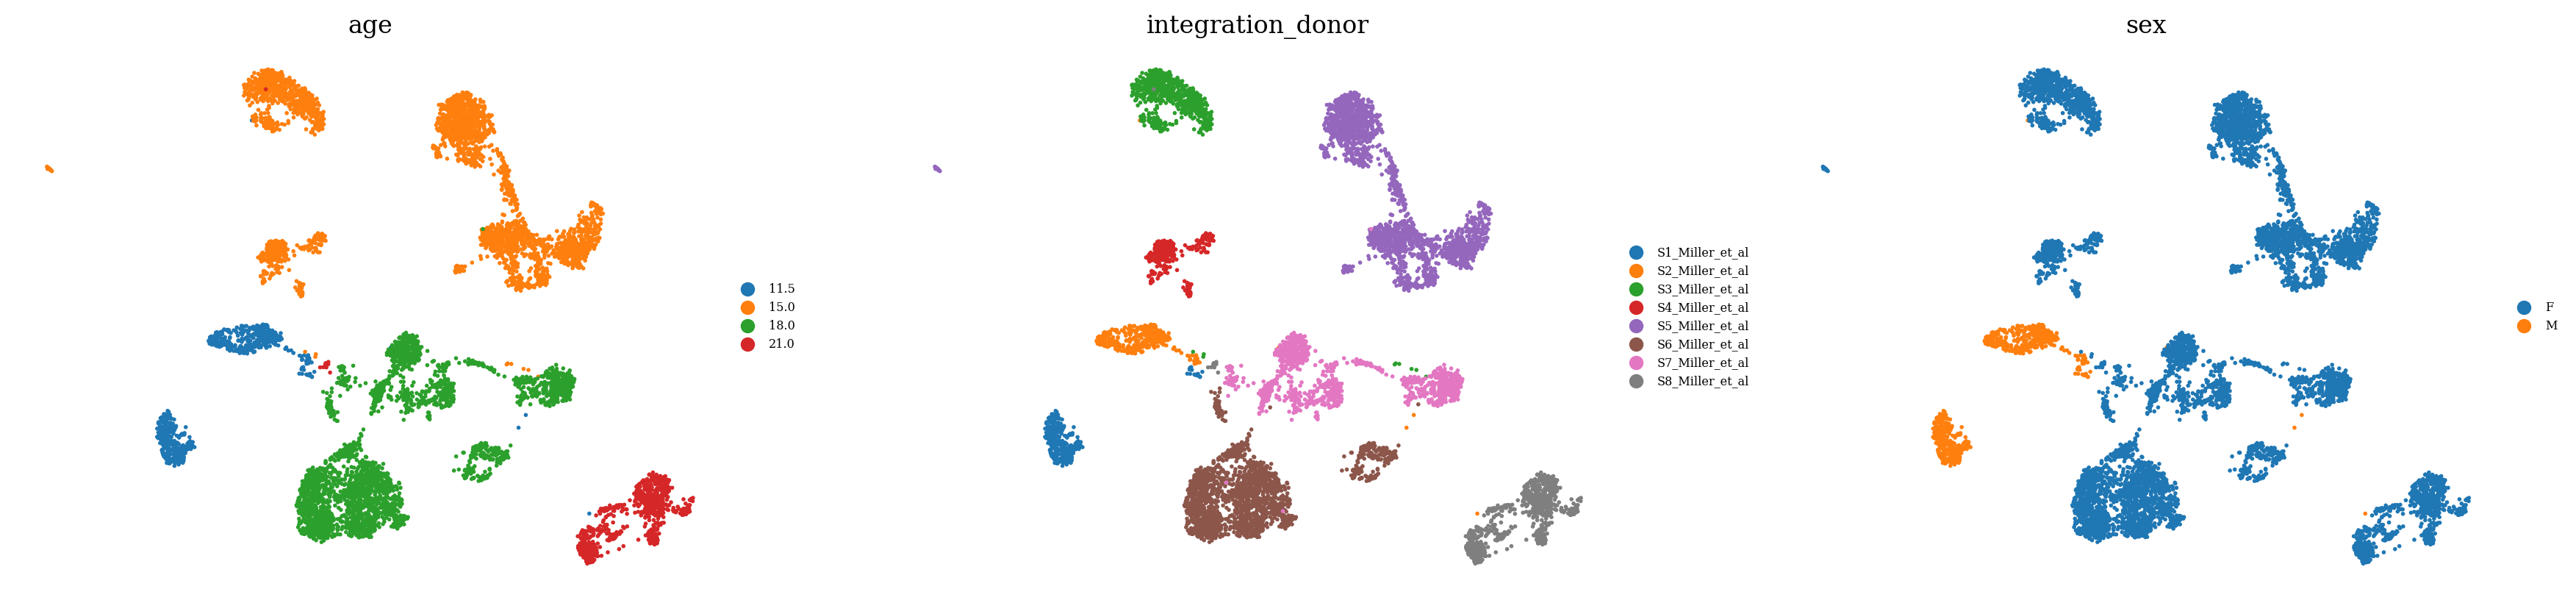

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

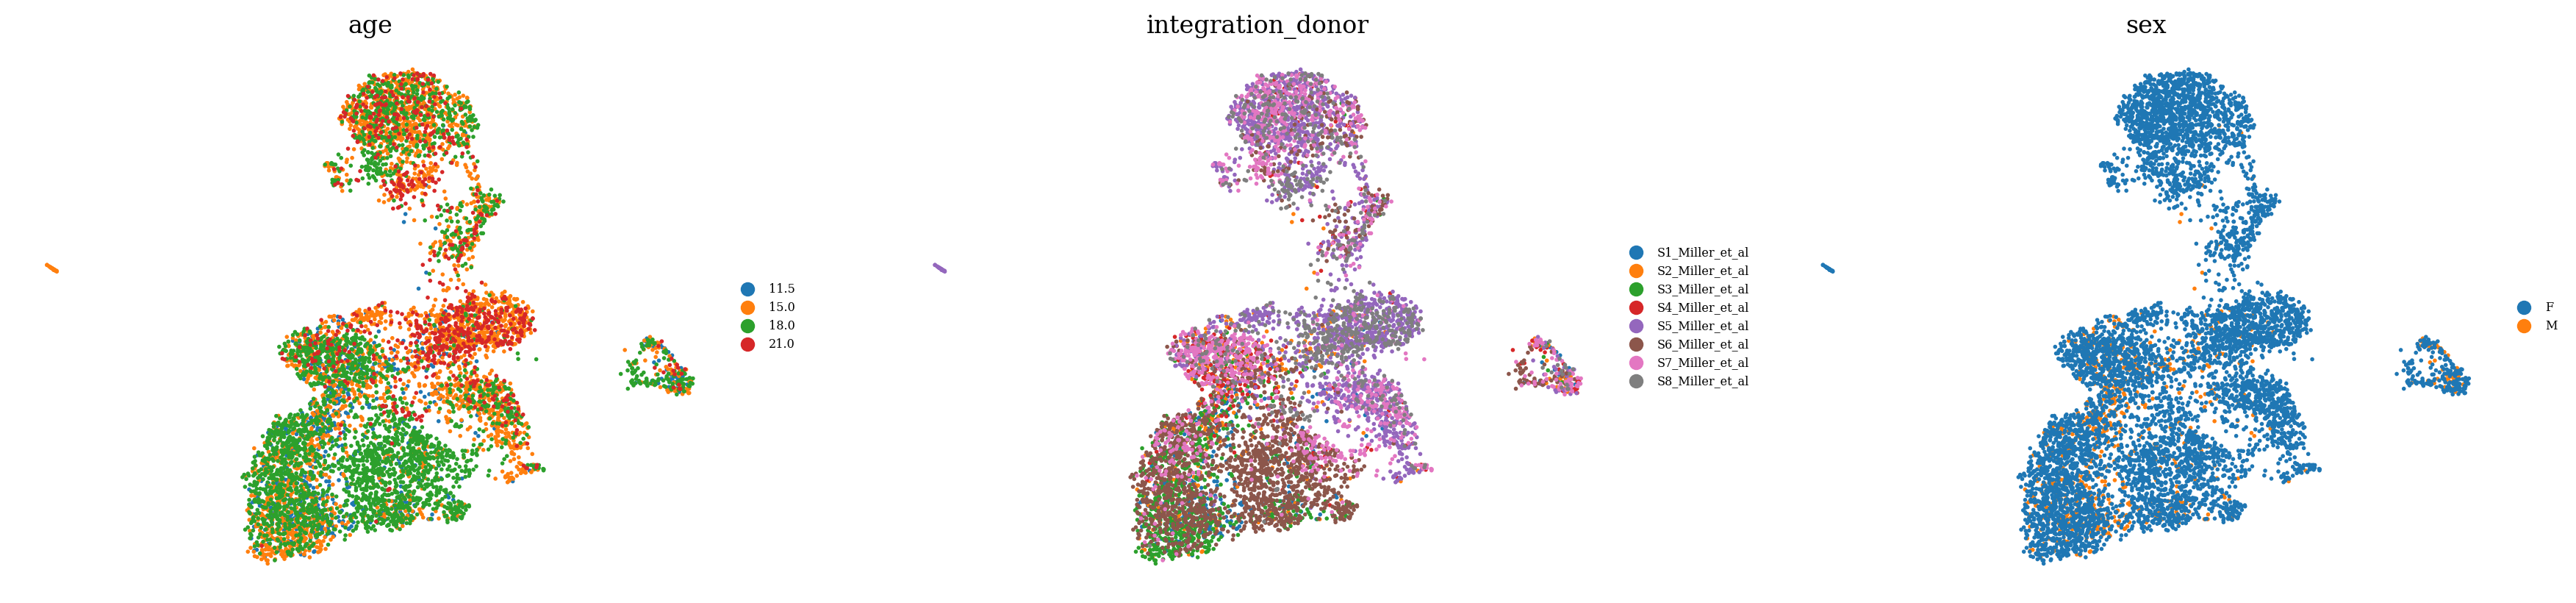

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  5%|▌         | 12/232 [00:00<00:01, 119.20it/s]

 12%|█▎        | 29/232 [00:00<00:01, 145.97it/s]

 21%|██        | 48/232 [00:00<00:01, 164.15it/s]

 28%|██▊       | 66/232 [00:00<00:01, 165.27it/s]

 36%|███▌      | 83/232 [00:00<00:01, 142.14it/s]

 42%|████▏     | 98/232 [00:00<00:01, 131.97it/s]

 48%|████▊     | 112/232 [00:00<00:00, 125.97it/s]

 54%|█████▍    | 125/232 [00:00<00:00, 119.66it/s]

 59%|█████▉    | 138/232 [00:01<00:00, 117.95it/s]

 65%|██████▍   | 150/232 [00:01<00:00, 101.55it/s]

 69%|██████▉   | 161/232 [00:01<00:00, 103.01it/s]

 75%|███████▍  | 173/232 [00:01<00:00, 105.86it/s]

 80%|███████▉  | 185/232 [00:01<00:00, 107.95it/s]

 85%|████████▍ | 197/232 [00:01<00:00, 109.40it/s]

 90%|█████████ | 209/232 [00:01<00:00, 109.20it/s]

 95%|█████████▌| 221/232 [00:01<00:00, 109.66it/s]

100%|██████████| 232/232 [00:01<00:00, 118.31it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.591344893120753

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)